In [1]:
from os import environ as ENV
DATA = ENV['PWD'] + '/data/'
FIGS = ENV['PWD'] + '/figures/'

In [2]:
import sys
sys.path.append('../src')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

In [3]:
import pandas as pd
import bct
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons]
coords = get_coords(record).loc[sig_neurons]

In [5]:
# prepare plots, disable to minimize lag
plt.rcParams['figure.dpi'] = 300

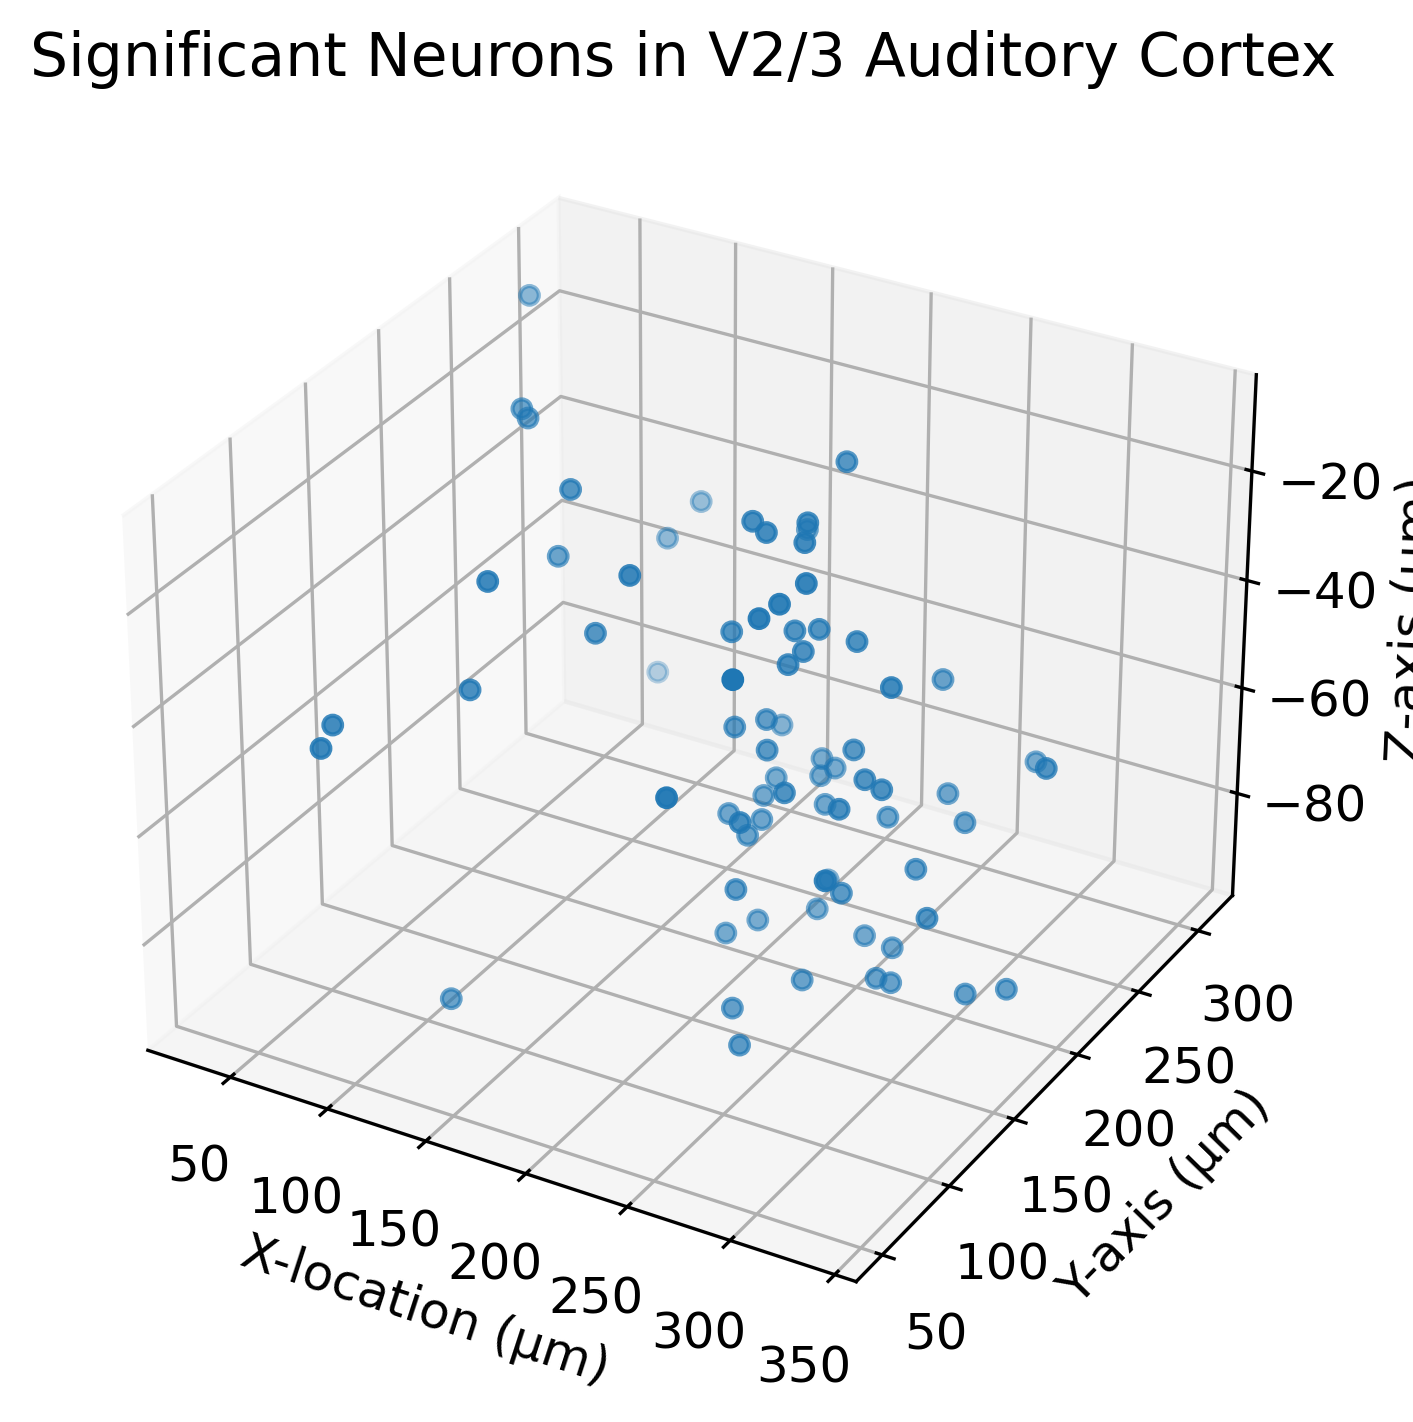

In [6]:
# Correlation mapping of significant neurons in V2/3 Auditory Cortex
plt.rcParams['font.size'] = 12
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(coords['x'], coords['y'], coords['z'])
ax.set_xlabel('X-location (µm)')
ax.set_ylabel('Y-axis (µm)')
ax.set_zlabel('Z-axis (µm)')
ax.set_title('Significant Neurons in V2/3 Auditory Cortex')
plt.tight_layout()
plt.savefig(FIGS + 'sig_neurons_cortex.png', dpi=300)
plt.show()

In [7]:
# load data
quantum_fidelity_amp_qft_df = pd.read_csv(DATA + 'results_simulator_amp-qft.csv', index_col=0)
quantum_fidelity_amp_qft_df.columns = [int(i) for i in quantum_fidelity_amp_qft_df.columns]

quantum_fidelity_amp_df = pd.read_csv(DATA + 'results_simulator_amp.csv', index_col=0)
quantum_fidelity_amp_df.columns = [int(i) for i in quantum_fidelity_amp_df.columns]

quantum_fidelity_ang_df = pd.read_csv(DATA + 'results_simulator_ang.csv', index_col=0)
quantum_fidelity_ang_df.columns = [int(i) for i in quantum_fidelity_ang_df.columns]

corrs_df = pd.read_csv(DATA + 'classical-correlations.csv', index_col=0)
corrs_df.columns = [int(i) for i in corrs_df.columns]

euclidean_dist_df = pd.read_csv(DATA + 'euclidean_distance.csv', index_col=0)
euclidean_dist_df.columns = [int(float(i)) for i in euclidean_dist_df.columns]

classical_fidelity_df = pd.read_csv(DATA + 'classical_fidelity.csv', index_col=0)
classical_fidelity_df.columns = [int(float(i)) for i in classical_fidelity_df.columns]

In [8]:
def rescale(x):
    flat = x.to_numpy().flatten()
    return (flat - np.min(flat)) / (np.max(flat) - np.min(flat))

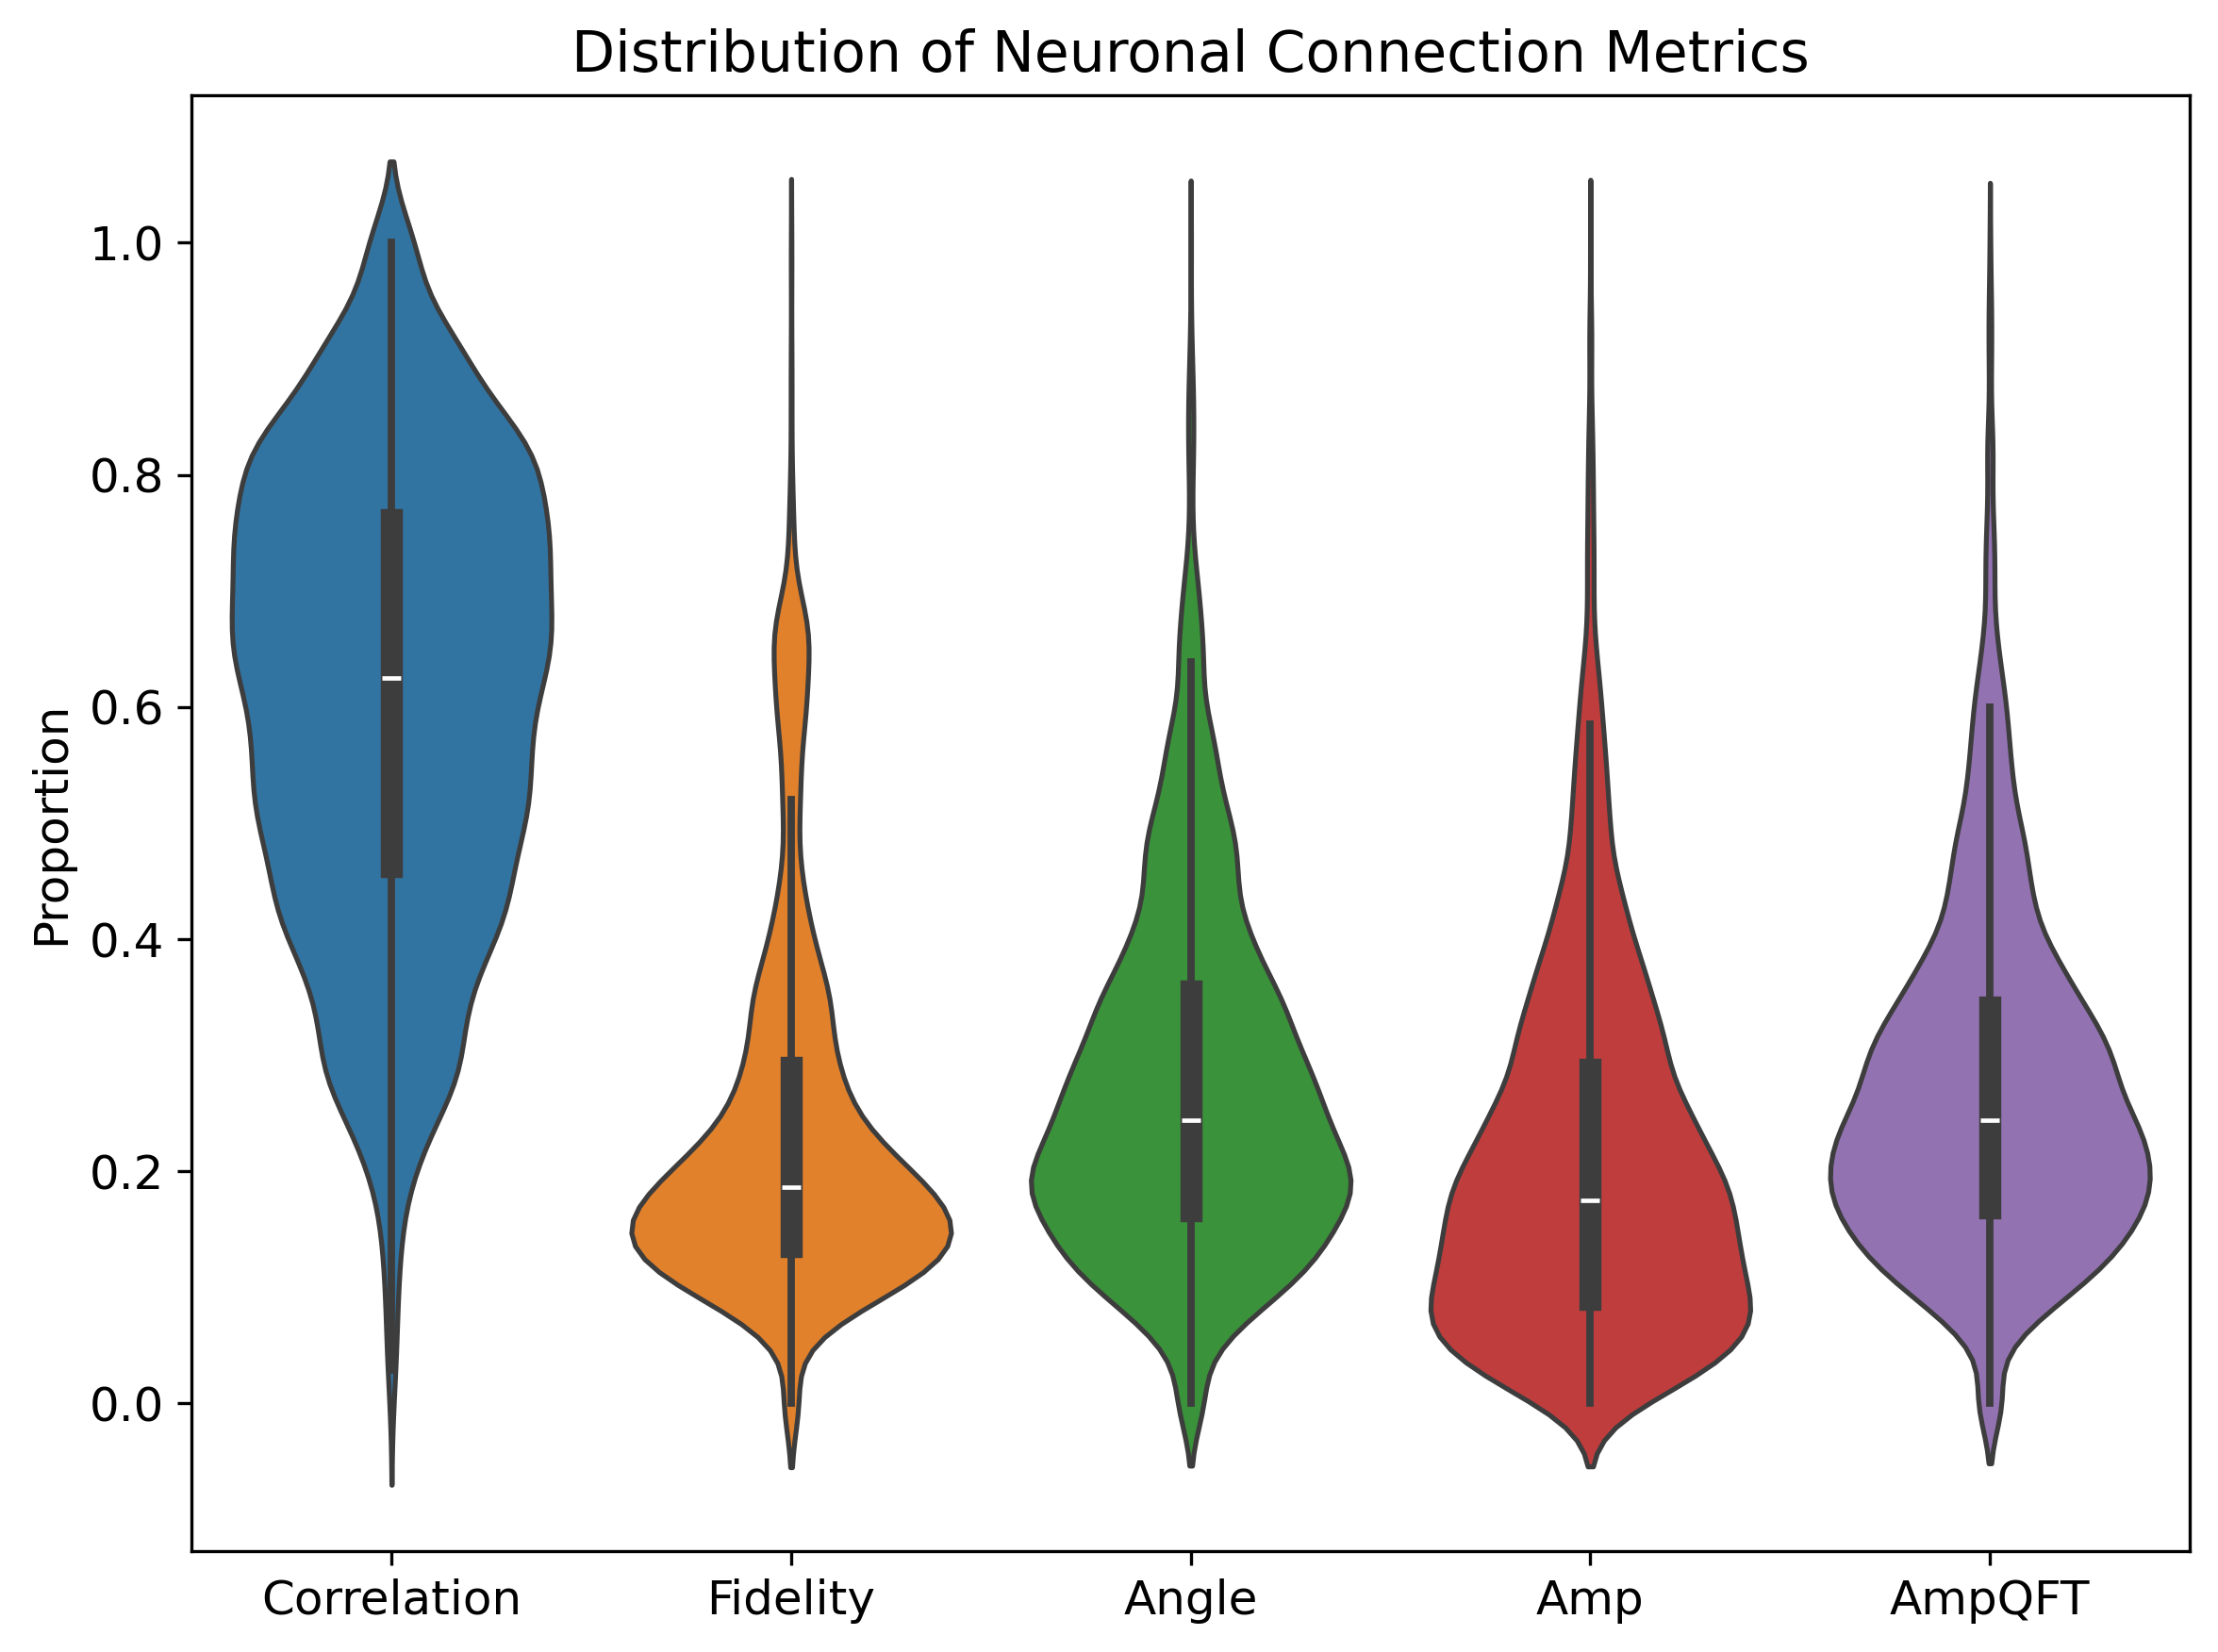

In [9]:
plt.rcParams['font.size'] = 12

plt.close()
# Plot Distribution of Neuronal Connection Distances
plt.figure(figsize=(8, 6))

data_dict = {
    'Correlation': rescale(corrs_df), # add 1 to make corrs non-negative
    # 'Euclidean': rescale(euclidean_dist_df),
    'Fidelity': rescale(classical_fidelity_df),
    'Angle': rescale(1-quantum_fidelity_ang_df),
    'Amp': rescale(1-quantum_fidelity_amp_df),
    'AmpQFT': rescale(1-quantum_fidelity_amp_qft_df),
}
sns.violinplot(data_dict)

# plt.xlabel("Metric name")
plt.ylabel("Proportion")
plt.title("Distribution of Neuronal Connection Metrics")
plt.tight_layout()
plt.show()

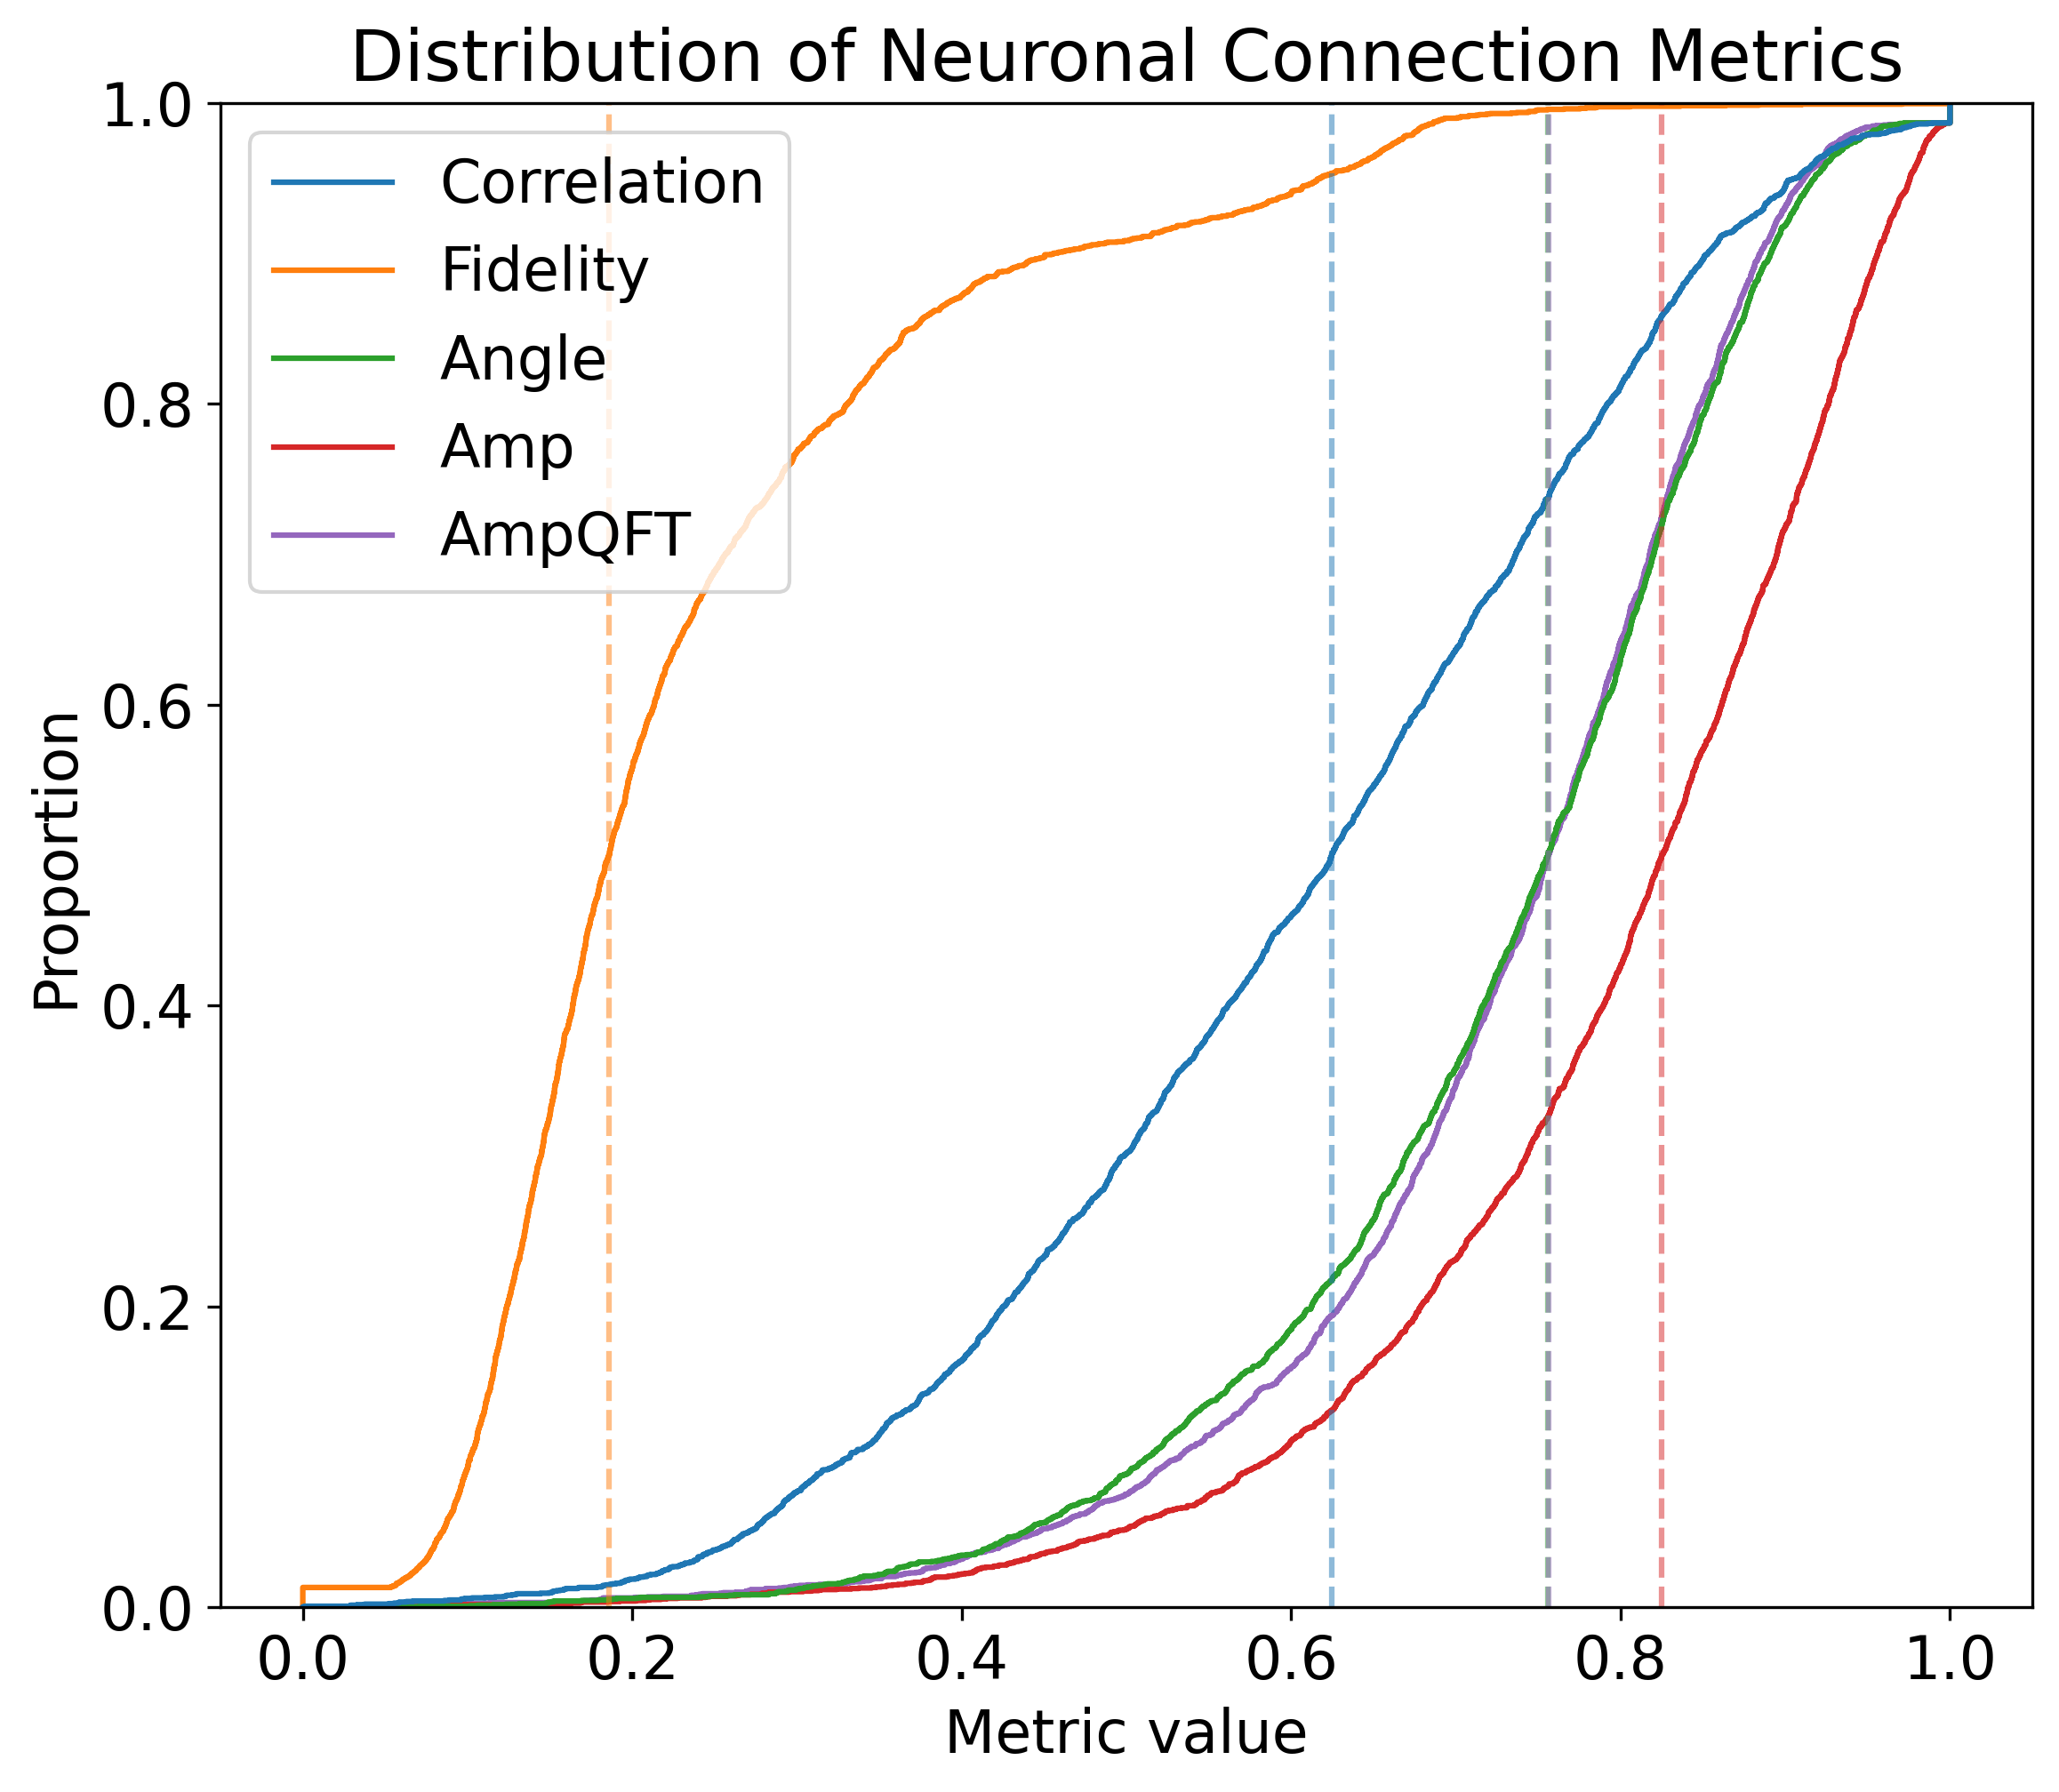

In [10]:
plt.rcParams['font.size'] = 16

plt.close()
# Plot Distribution of Neuronal Connection Distances
plt.figure(figsize=(8, 7))
default_palette = sns.color_palette()
first_five_colors = default_palette[:5]

data_dict = {
    'Correlation': rescale(corrs_df), # add 1 to make corrs non-negative
    # 'Euclidean': rescale(euclidean_dist_df),
    'Fidelity': rescale(classical_fidelity_df),
    'Angle': rescale(quantum_fidelity_ang_df),
    'Amp': rescale(quantum_fidelity_amp_df),
    'AmpQFT': rescale(quantum_fidelity_amp_qft_df),
}
sns.ecdfplot(data_dict)
i=0
for metric, data in data_dict.items():
    median_x = np.median(data)
    plt.axvline(median_x, linestyle='--', alpha=0.5, c=default_palette[i])
    i+=1

plt.xlabel("Metric value")
plt.ylabel("Proportion")
plt.title("Distribution of Neuronal Connection Metrics")
handles, labels = ax.get_legend_handles_labels()

plt.tight_layout()
plt.show()

In [11]:
import itertools

In [12]:
def make_graph(dist_matrix):
    # Minimum Spanning Tree (MST)
    G = nx.Graph()
    for i in dist_matrix.index:
        G.add_node(i, pos=coords.loc[i])
    for (i, j) in itertools.combinations(dist_matrix.index, 2):
        G.add_edge(i, j, weight=dist_matrix.loc[i][j])
    return G

In [13]:
import networkx as nx
# draw graphs


In [14]:
# MST of fidelity is maximize 1-fidelity
matrices = [
    corrs_df,
    # euclidean_dist_df,
    classical_fidelity_df,
    1-quantum_fidelity_ang_df,
    1-quantum_fidelity_amp_df,
    1-quantum_fidelity_amp_qft_df,
]

In [15]:
graphs = [make_graph(i) for i in matrices]
graph_labels = [ "Correlation", "Fidelity", "Angle", "Amp", "AmpQFT",]

In [16]:
def remove_edges_under_percentile(G, percentile):
    new_G = G.copy()
    # Get edge weights
    edge_weights = [G[u][v]['weight'] for u, v in G.edges() if G[u][v]['weight'] is not None]

    # Calculate percentile
    threshold = np.percentile(edge_weights, percentile)

    # Identify and remove edges
    edges_to_remove = [(u, v) for u, v in new_G.edges() if new_G[u][v]['weight'] < threshold]
    new_G.remove_edges_from(edges_to_remove)

    return new_G

In [17]:
# threshold graphs not with bctpy but with networkx
# import bct
msts = [nx.minimum_spanning_tree(g) for g in graphs]
threshold_95 = [remove_edges_under_percentile(g, 95) for g in graphs]
threshold_90 = [remove_edges_under_percentile(g, 90) for g in graphs]


## Verify sparsity conditions

need to threshold graphs such that the average degree is >2 but less than the square-root of the number of neurons to get region of intermediate sparsity (<https://www.nature.com/articles/s41467-019-08746-5>)

In [18]:
def average_degree(G):
    return 2 * G.number_of_edges() / G.number_of_nodes()

In [19]:
all([average_degree(g) < 76**0.5 for g in msts])


True

In [20]:
all([average_degree(g) < 76**0.5 for g in threshold_95])

True

In [21]:
all([average_degree(g) < 76**0.5 for g in threshold_90])


True

# Plotting networks

## 2D

In [22]:
def plot_graph_circular(G, title, ax):
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=10, node_color='royalblue')
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=weights.min(), vmax=weights.max())
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, alpha=0.6)

    ax.set_title(title, fontsize=20)
    ax.set_frame_on(False)
    ax.set_axis_off()


In [23]:
def plot_2d_wrapper_grid_T(graph_lists, suffixes, graph_labels):
    plt.rcParams['font.size'] = 16
    
    fig, axes = plt.subplots(5, 3, figsize=(13, 20))
    axes = axes.flatten()
    j = 0
    labels = iter(graph_labels)
    for graphs, sfx in zip(graph_lists, suffixes):
        for i in range(len(graphs)):
            plot_graph_circular(graphs[i], graph_labels[i], axes[j])
            if j >= 3:
                axes[j].set_title('') # hide title of columns
            else:
                axes[j].set_title(next(labels))
            if j % 3 == 0:
                axes[j].set_axis_on()
                axes[j].set_frame_on(False)
                axes[j].set_ylabel(sfx, fontsize=20, rotation=0, ha='right')
            j+=1

    plt.suptitle('2D functional networks', fontsize=28)
    plt.tight_layout()
    plt.savefig(FIGS + 'network-2d-grid.png', dpi=300)


In [24]:
# transpose the grid before graphing
plot_2d_wrapper_grid_T(
    list(zip(*[msts, threshold_95, threshold_90])),
                     graph_labels,
                     ['MST', 'Top 5%', 'Top 10%']
                    )
# big figure
plt.clf()
plt.close()

## 3D

In [25]:
def plot_graph_3d(G, title, ax, node_color='royalblue'):
    plt.rcParams['font.size'] = 16
    
    pos = nx.get_node_attributes(G, 'pos')
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=weights.min(), vmax=weights.max())

    for u, v in G.edges():
        x = [pos[u]['x'], pos[v]['x']]
        y = [pos[u]['y'], pos[v]['y']]
        z = [pos[u]['z'], pos[v]['z']]
        weight = G[u][v]['weight']
        edge_color = cmap(norm(weight))
        ax.plot(x, y, z, color=edge_color, alpha=0.6)

    xs, ys, zs = zip(*pos.values())
    # print(xs, ys, zs)
    ax.scatter(xs, ys, zs, s=10, color=node_color)
    ax.set_title(title, fontsize=20)
    # ax.set_axis_off()
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('z')

In [26]:
def plot_3d_wrapper_grid_T(graph_lists, suffixes, graph_labels):

    plt.close()
    labels = iter(graph_labels)

    fig, axes = plt.subplots(5, 3, figsize=(12, 16), subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    j = 0
    for graphs, sfx in zip(graph_lists, suffixes):
        for i in range(len(graphs)):
            # print(j)
            plot_graph_3d(graphs[i], sfx, axes[j])
            if j >= 3:
                axes[j].set_title('') # hide title of columns
            else:
                axes[j].set_title(next(labels))
            j+=1

    plt.suptitle(f'3D functional networks', fontsize=28)
    plt.tight_layout()
    plt.savefig(FIGS + 'network-3d-grid.png', dpi=300)

    # plt.show()

In [27]:
plot_3d_wrapper_grid_T(
    list(zip(*[msts, threshold_95, threshold_90])),
                     graph_labels,
                     ['MST', 'top 5%', 'top 10%'])
# big figure
plt.clf()
plt.close()

# Difference Quantification

### Jaccard Differences, DeltaCon, and QuantumJSD and Portrait Divergence


In [28]:
from netrd.distance import JaccardDistance, DeltaCon, QuantumJSD, PortraitDivergence
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = []

for label, matrix in zip(graph_labels, matrices):
    # Build base graph
    G_full = make_graph(matrix)

    # Generate three subgraph variants
    G_mst = nx.minimum_spanning_tree(G_full)
    G_top5 = remove_edges_under_percentile(G_full, 95)
    G_top10 = remove_edges_under_percentile(G_full, 90)

    # All pairs to compare
    graph_pairs = [
        ("MST vs Top 5%", G_mst, G_top5),
        ("MST vs Top 10%", G_mst, G_top10),
        ("Top 5% vs Top 10%", G_top5, G_top10),
    ]

    # Calculate Jaccard, Deltacon, and QuantumJSD
    for comp_name, G1, G2 in graph_pairs:
        try:
            jacc = JaccardDistance().dist(G1, G2)
            deltacon = DeltaCon().dist(G1, G2)
            qjsd = QuantumJSD().dist(G1, G2)
            portraitd = PortraitDivergence().dist(G1, G2)
        except Exception as e:
            print(f"Error comparing {label} - {comp_name}: {e}")
            jacc, deltacon, qjsd, portraitd, edit_dist = None, None, None, None, None

        results.append({
            "Graph Type": label,
            "Comparison": comp_name,
            "Jaccard": jacc,
            "DeltaCon": deltacon,
            "QuantumJSD": qjsd,
            "PortraitDivergence": portraitd,
        })

# Place resutls in data frame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Graph Type", "Comparison"])

# Needed to quickly split comparison column
clean_df = results_df.copy()
clean_df[['Network1', 'Network2']] = clean_df['Comparison'].str.split(' vs ', expand=True)
clean_df = clean_df[['Graph Type', 'Network1', 'Network2', 'Jaccard', 'DeltaCon', 'QuantumJSD', 'PortraitDivergence']]

clean_df.round(3)

/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)
/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/netrd/distance/deltacon.py:105: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum(np.square(np.sqrt(X) - np.sqrt(Y))))


,Graph Type,Network1,Network2,Jaccard,DeltaCon,QuantumJSD,PortraitDivergence
10,Amp,MST,Top 10%,1.000,3.312,0.260,0.969
9,Amp,MST,Top 5%,1.000,2.801,0.186,0.983
11,Amp,Top 5%,Top 10%,0.498,1.760,0.124,0.303
13,AmpQFT,MST,Top 10%,1.000,4.268,0.267,0.807
12,AmpQFT,MST,Top 5%,1.000,3.747,0.197,0.860
14,AmpQFT,Top 5%,Top 10%,0.498,2.135,0.113,0.377
7,Angle,MST,Top 10%,1.000,2.394,0.272,0.852
6,Angle,MST,Top 5%,1.000,1.919,0.208,0.901
8,Angle,Top 5%,Top 10%,0.498,1.361,0.108,0.509
1,Correlation,MST,Top 10%,1.000,NaN,0.277,0.498


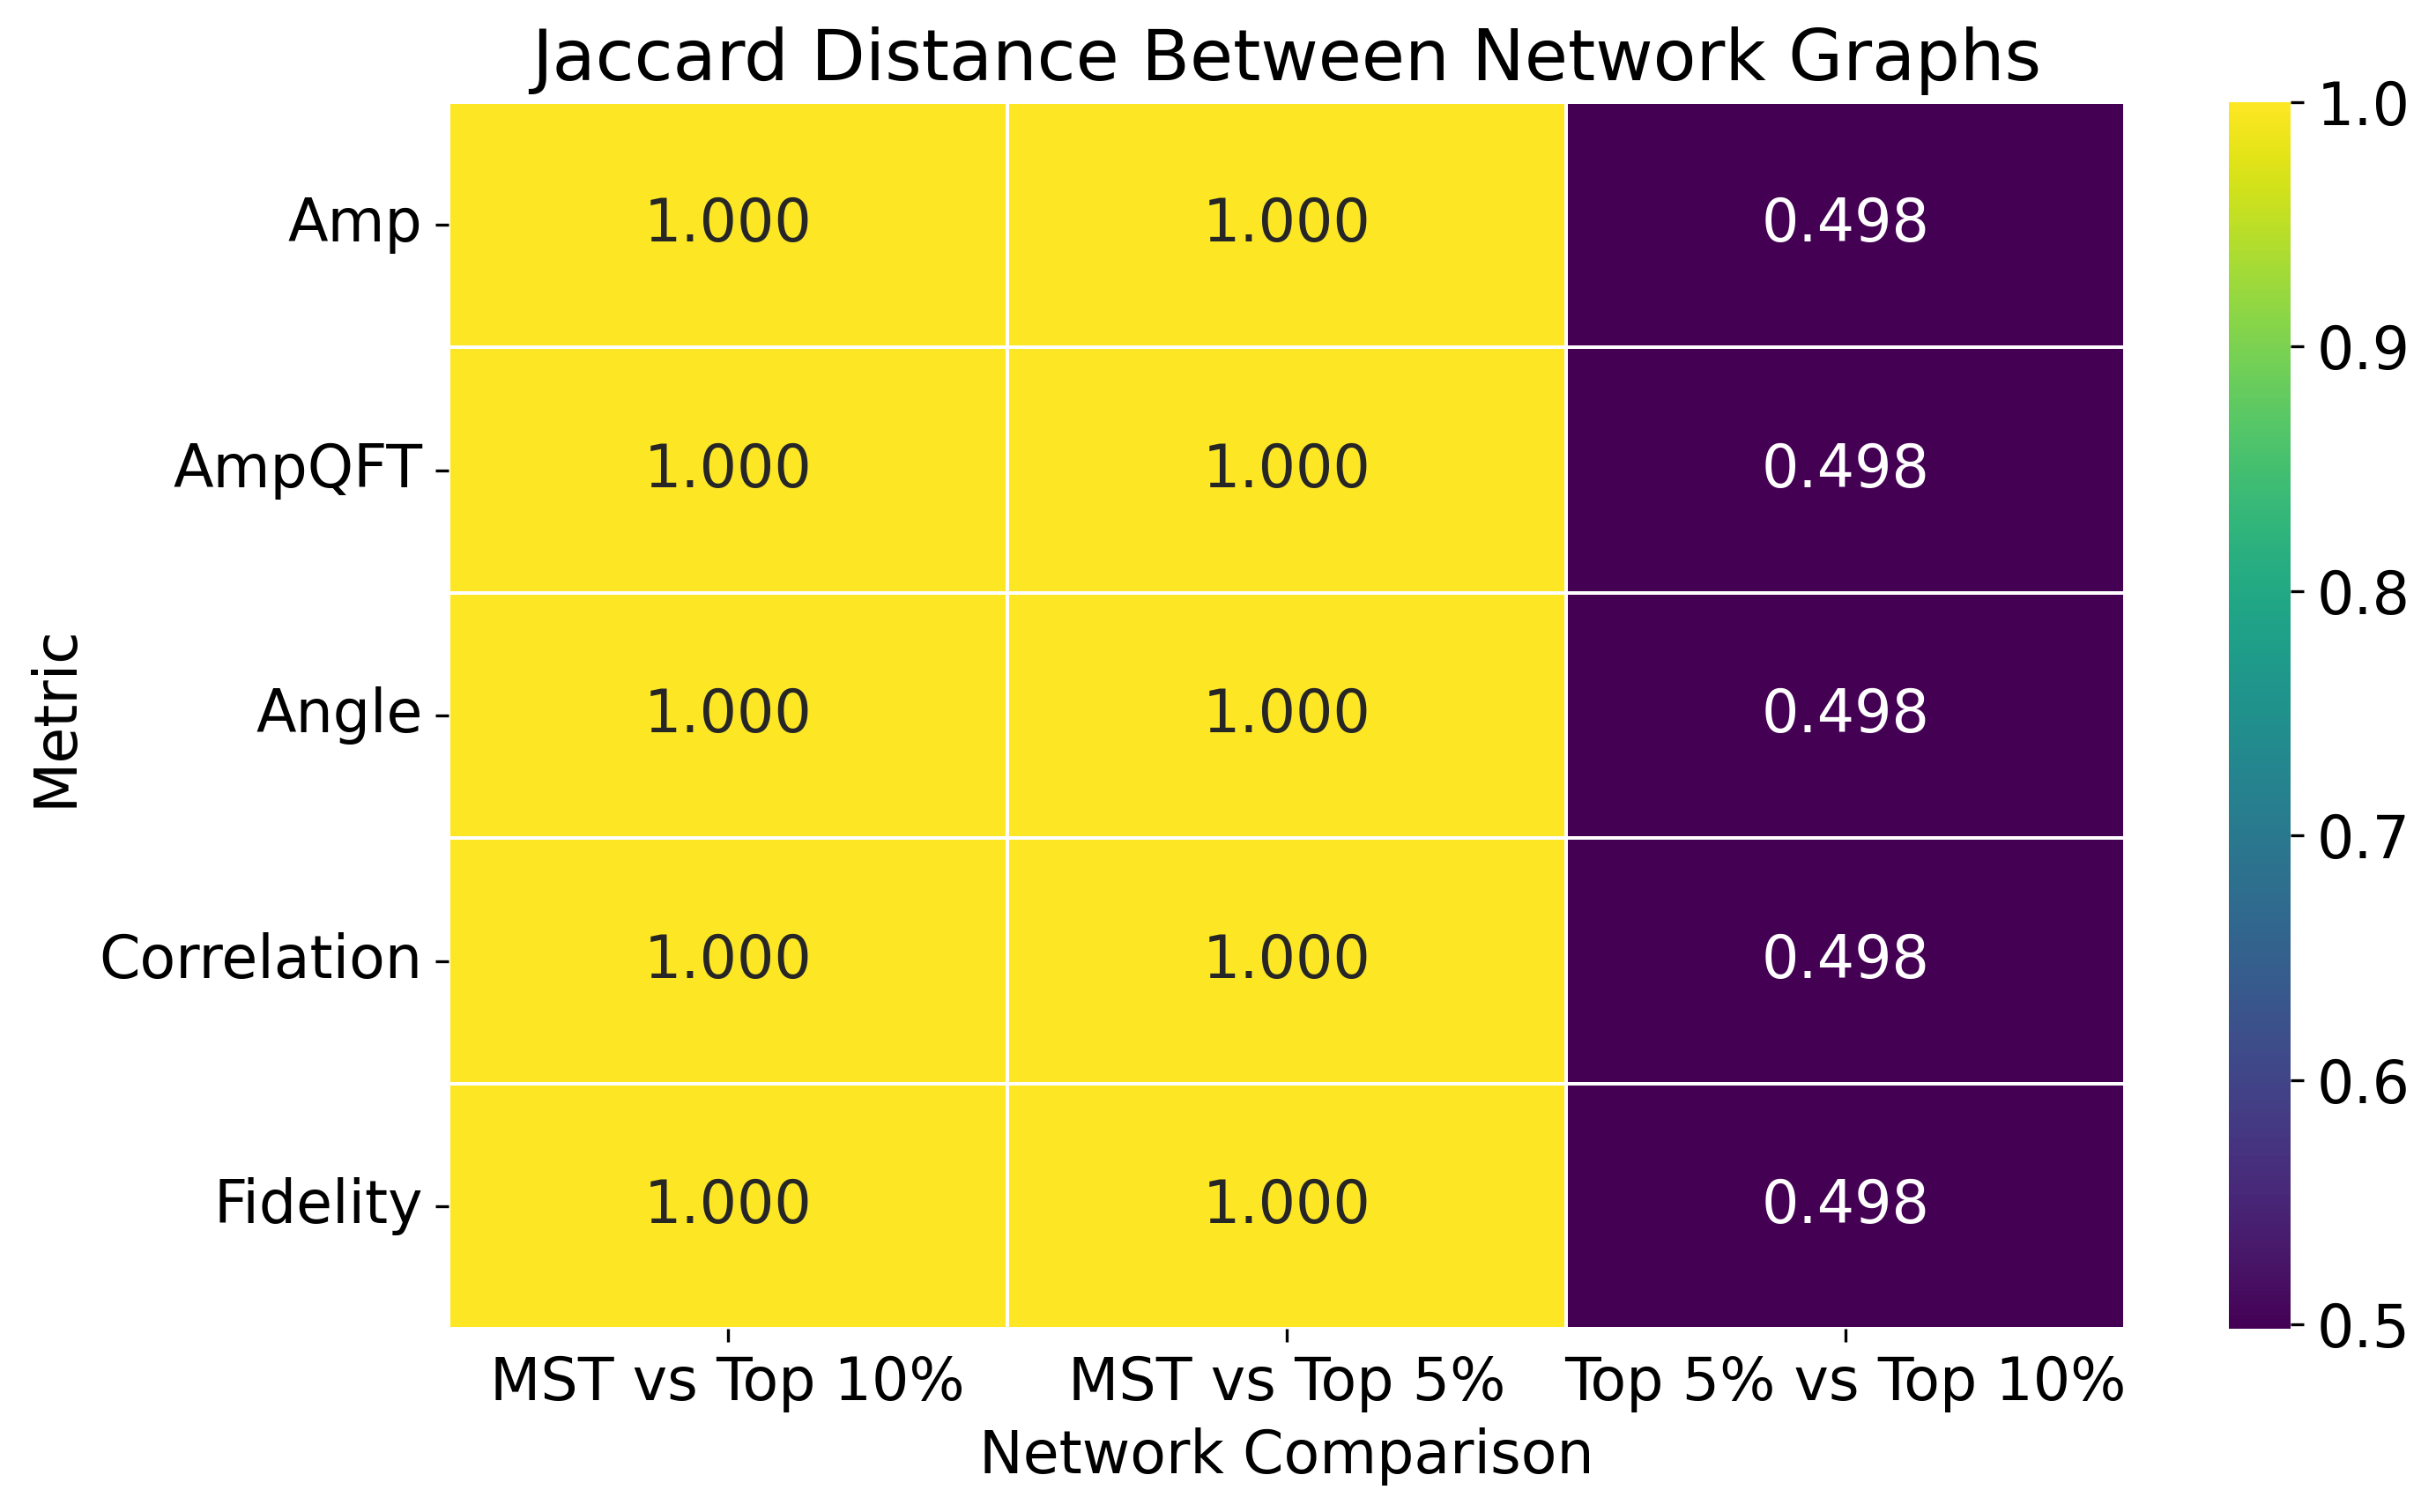

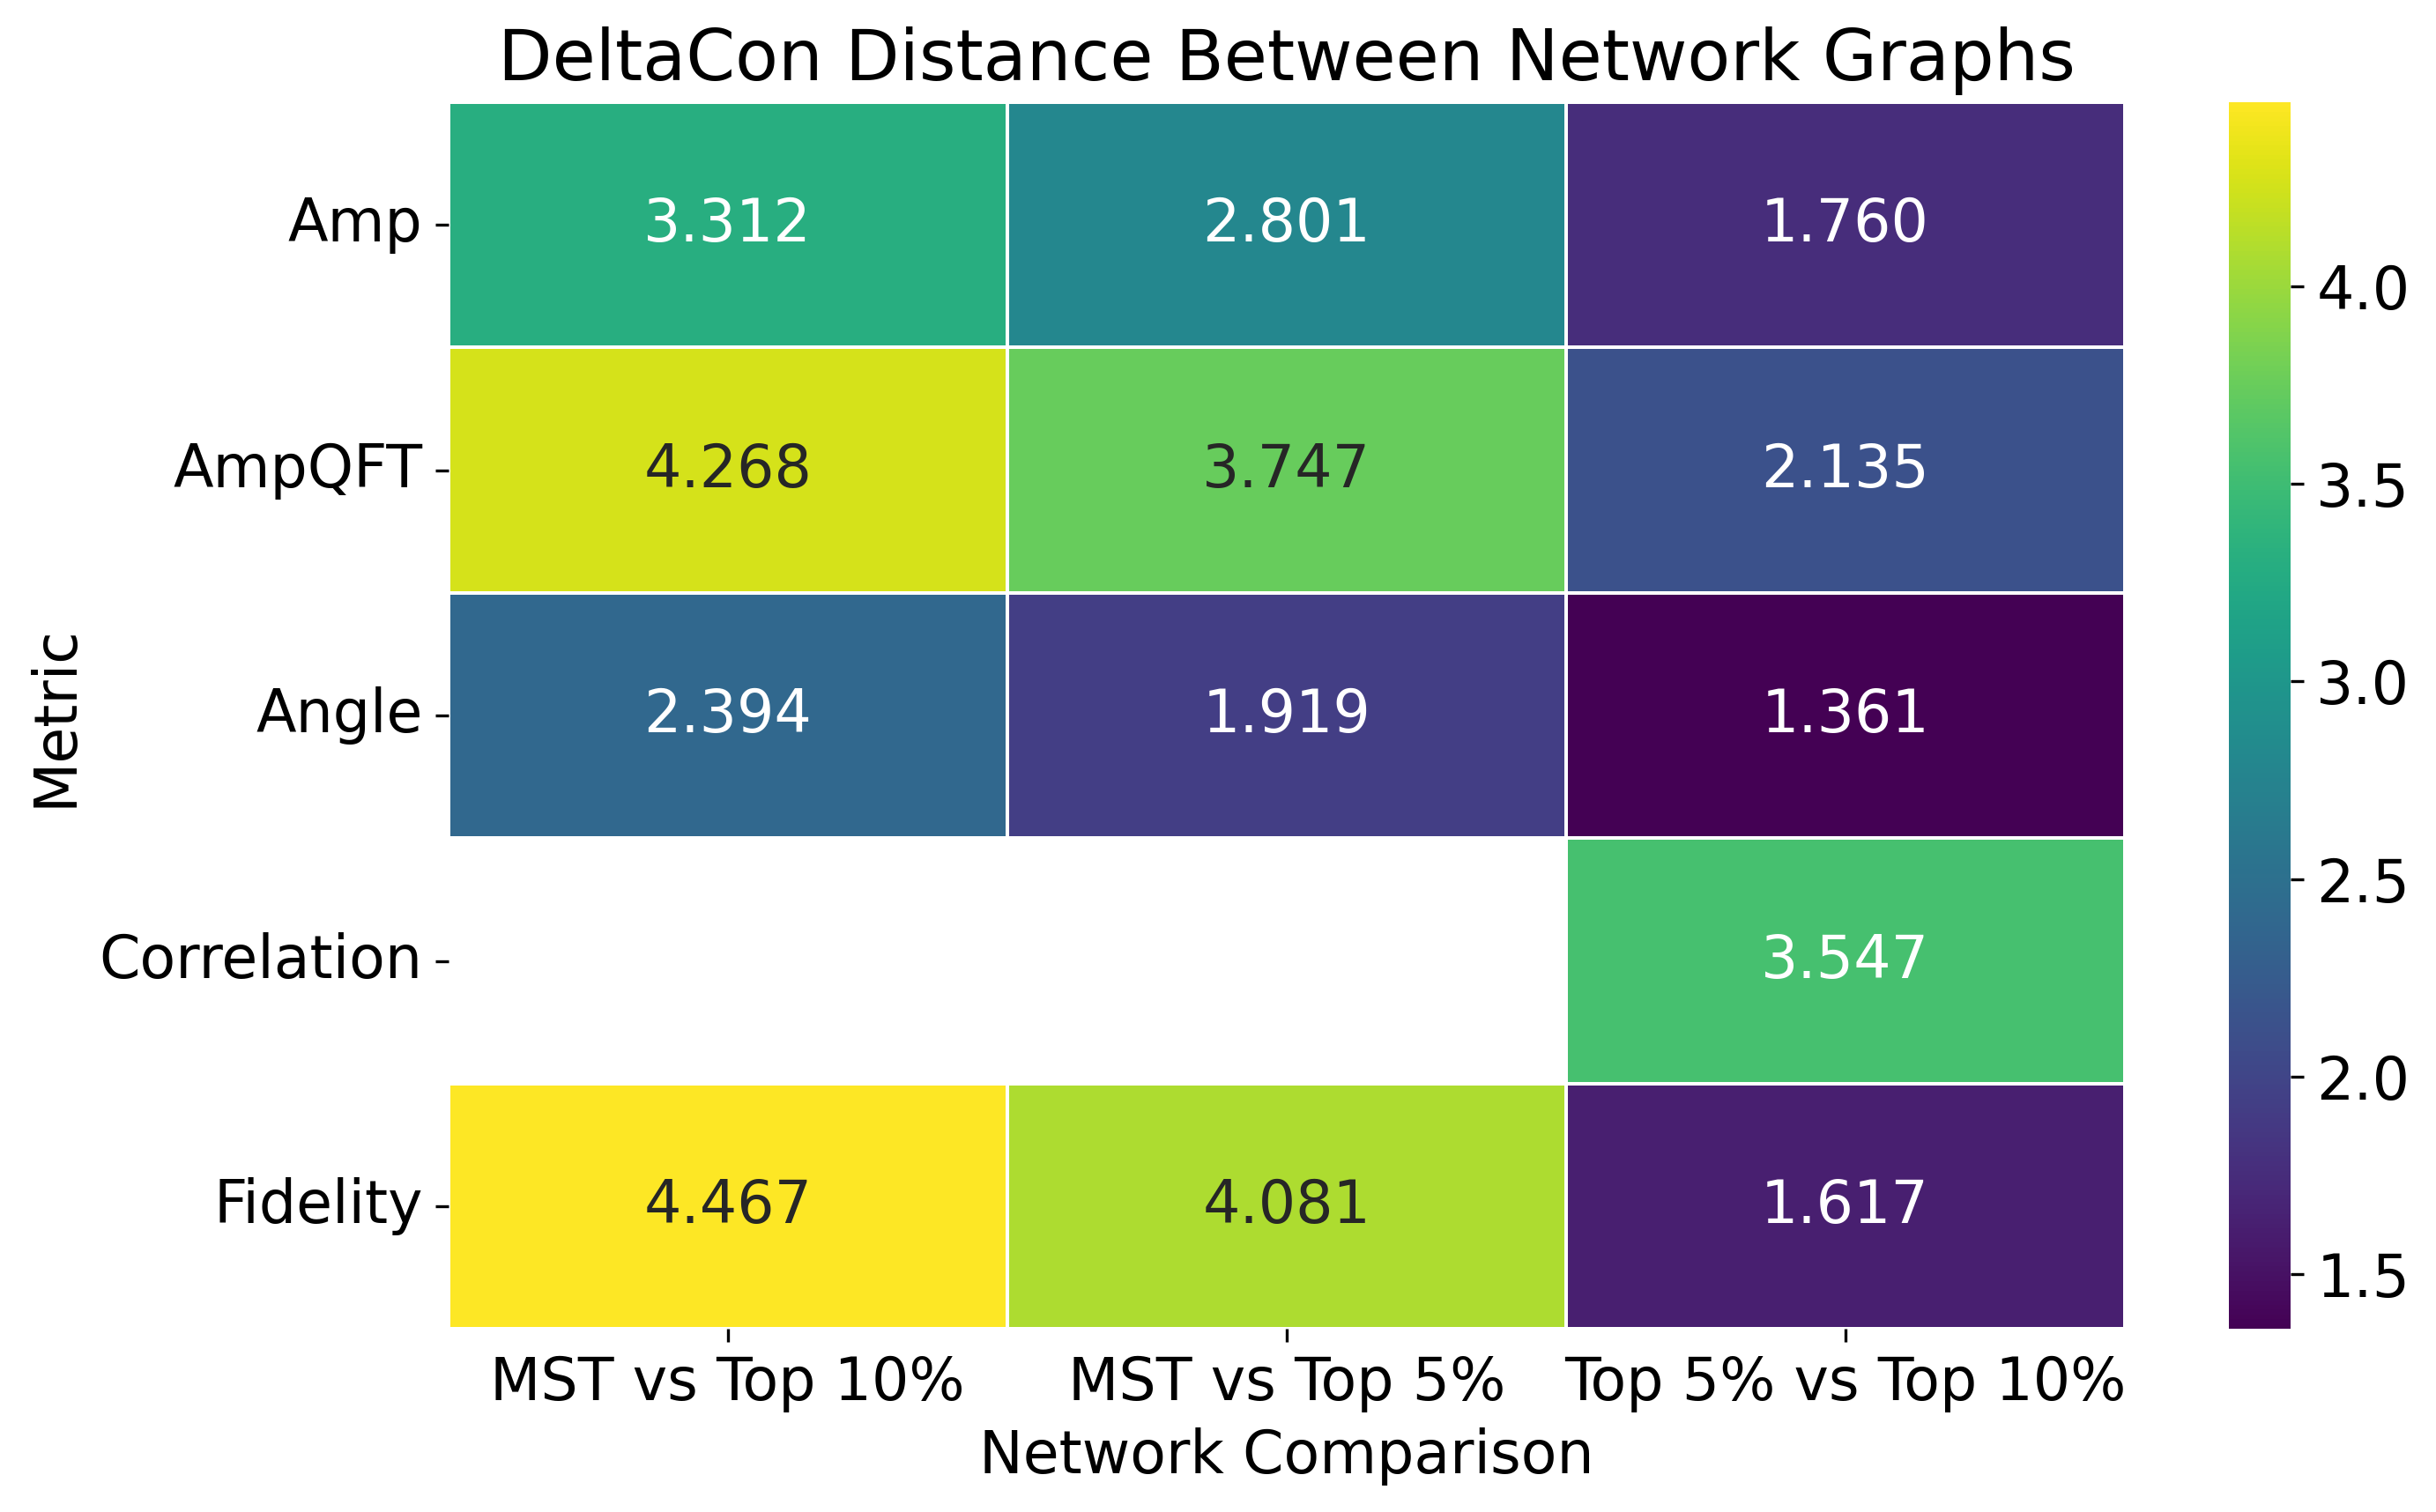

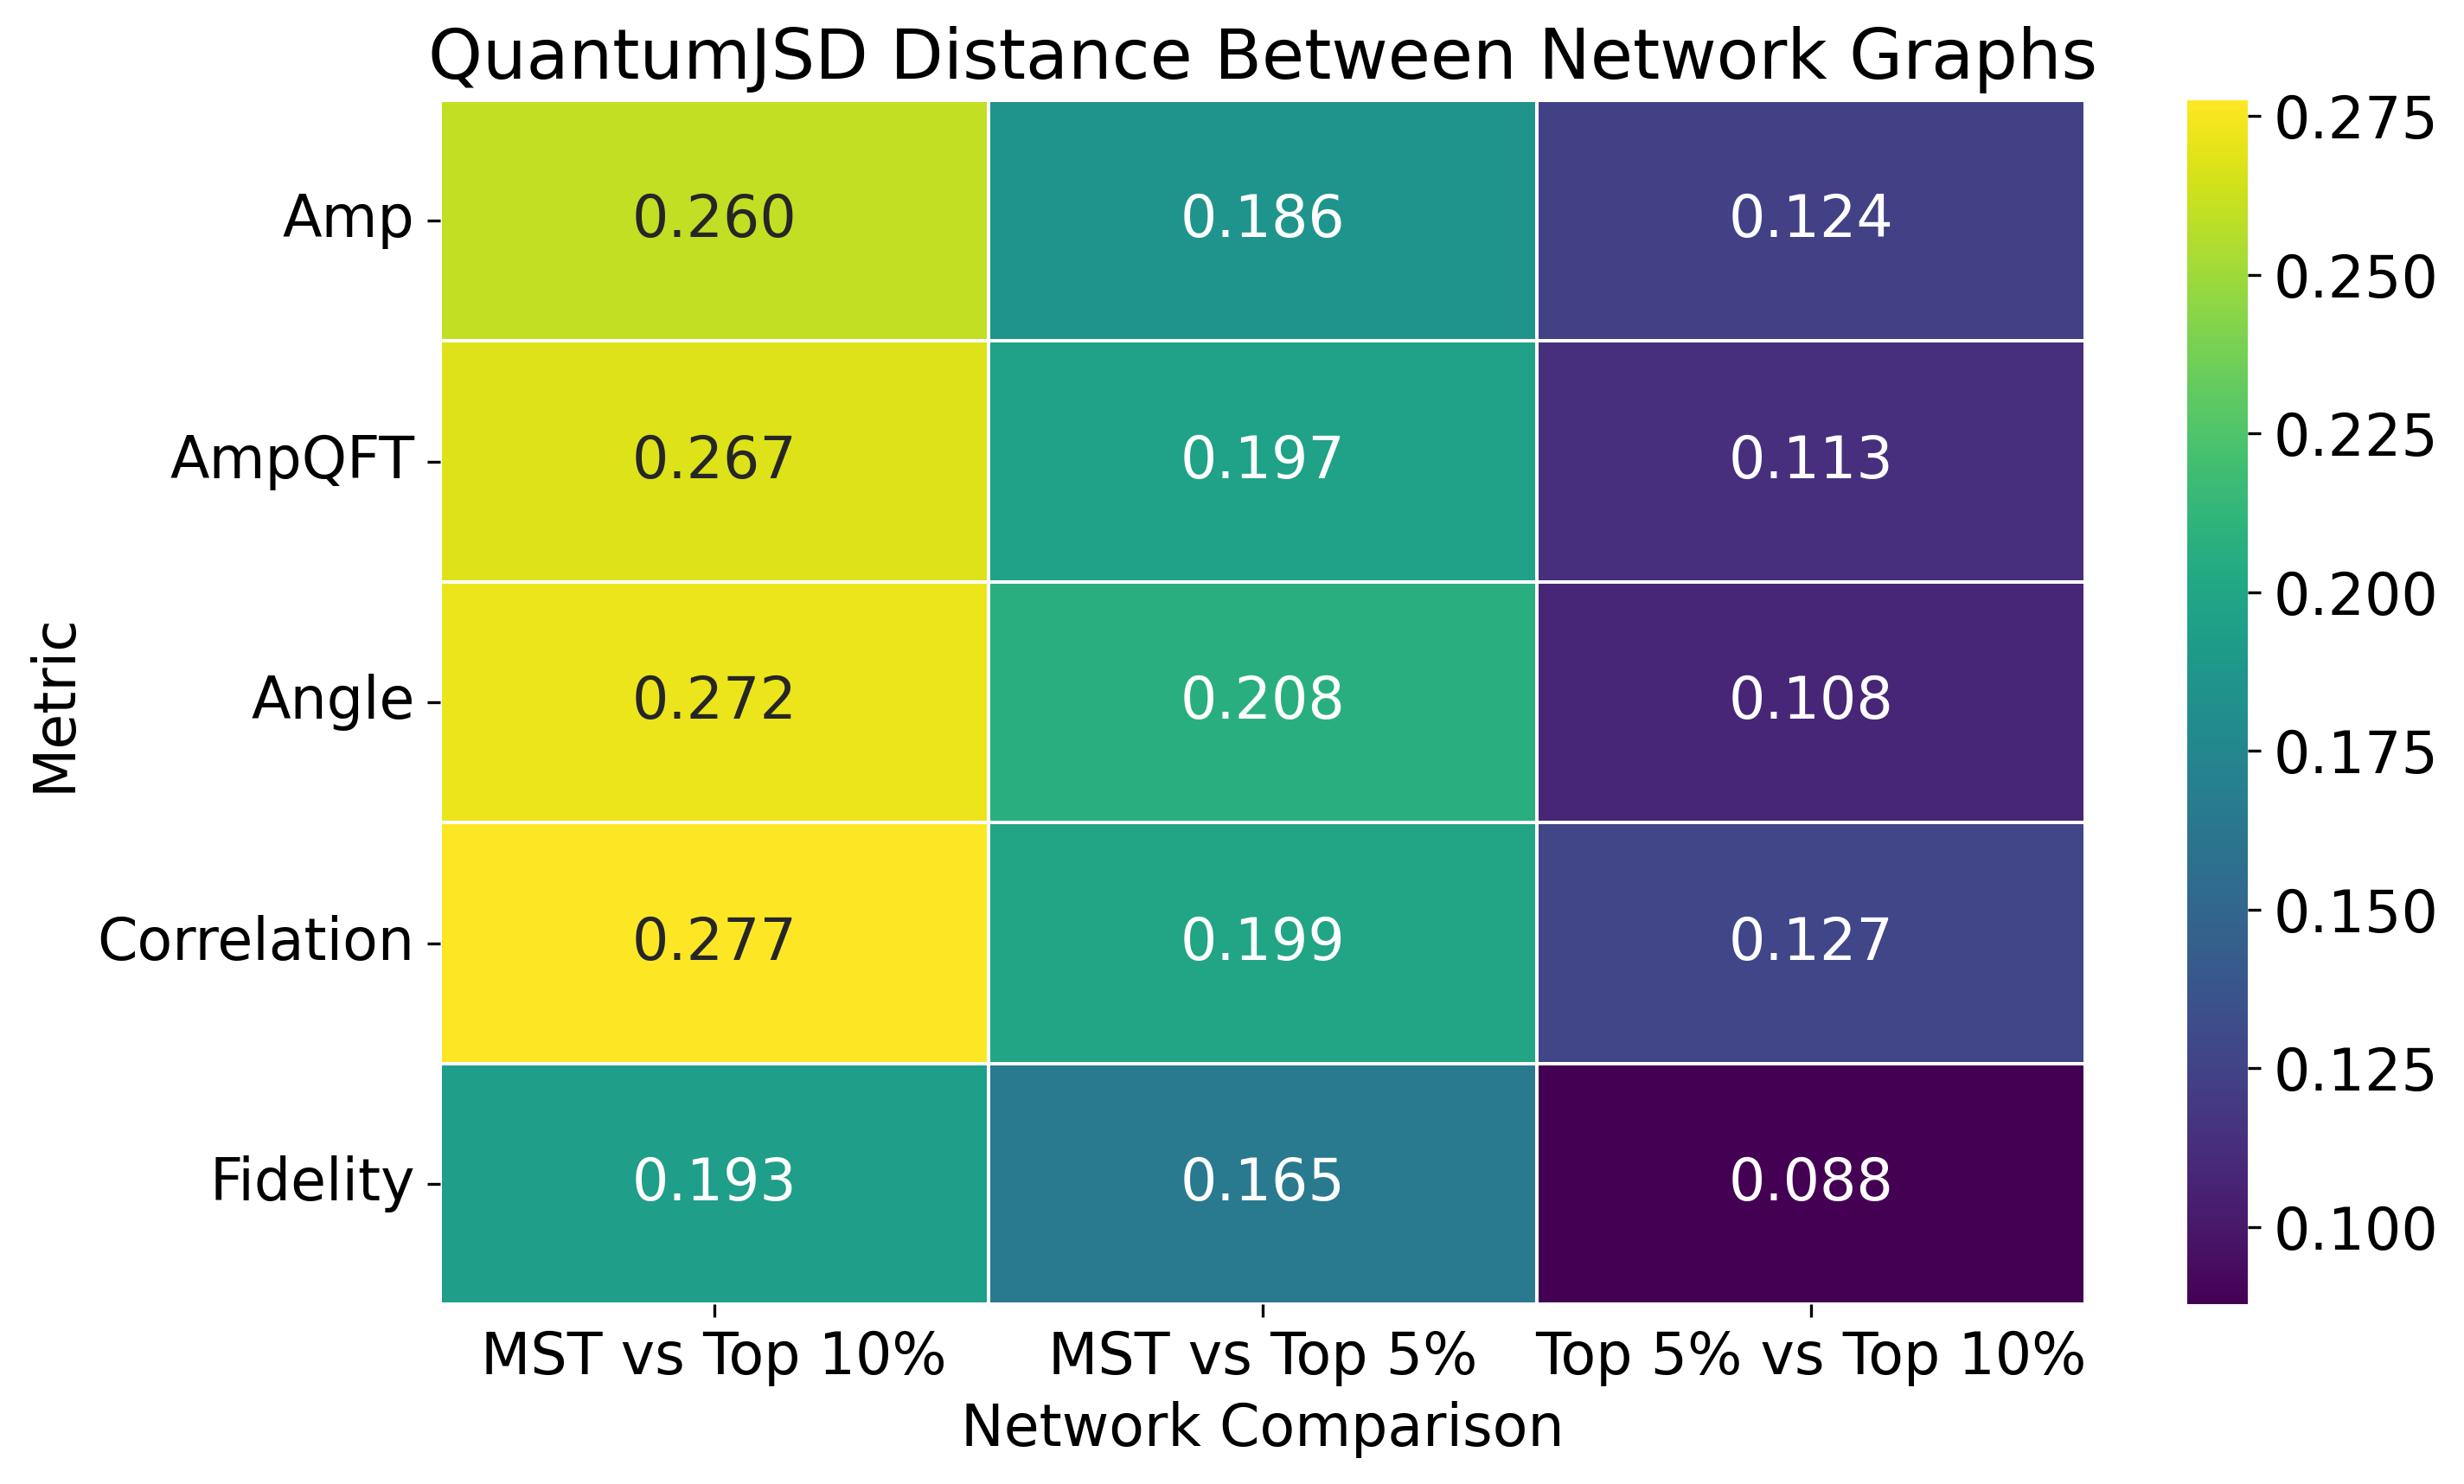

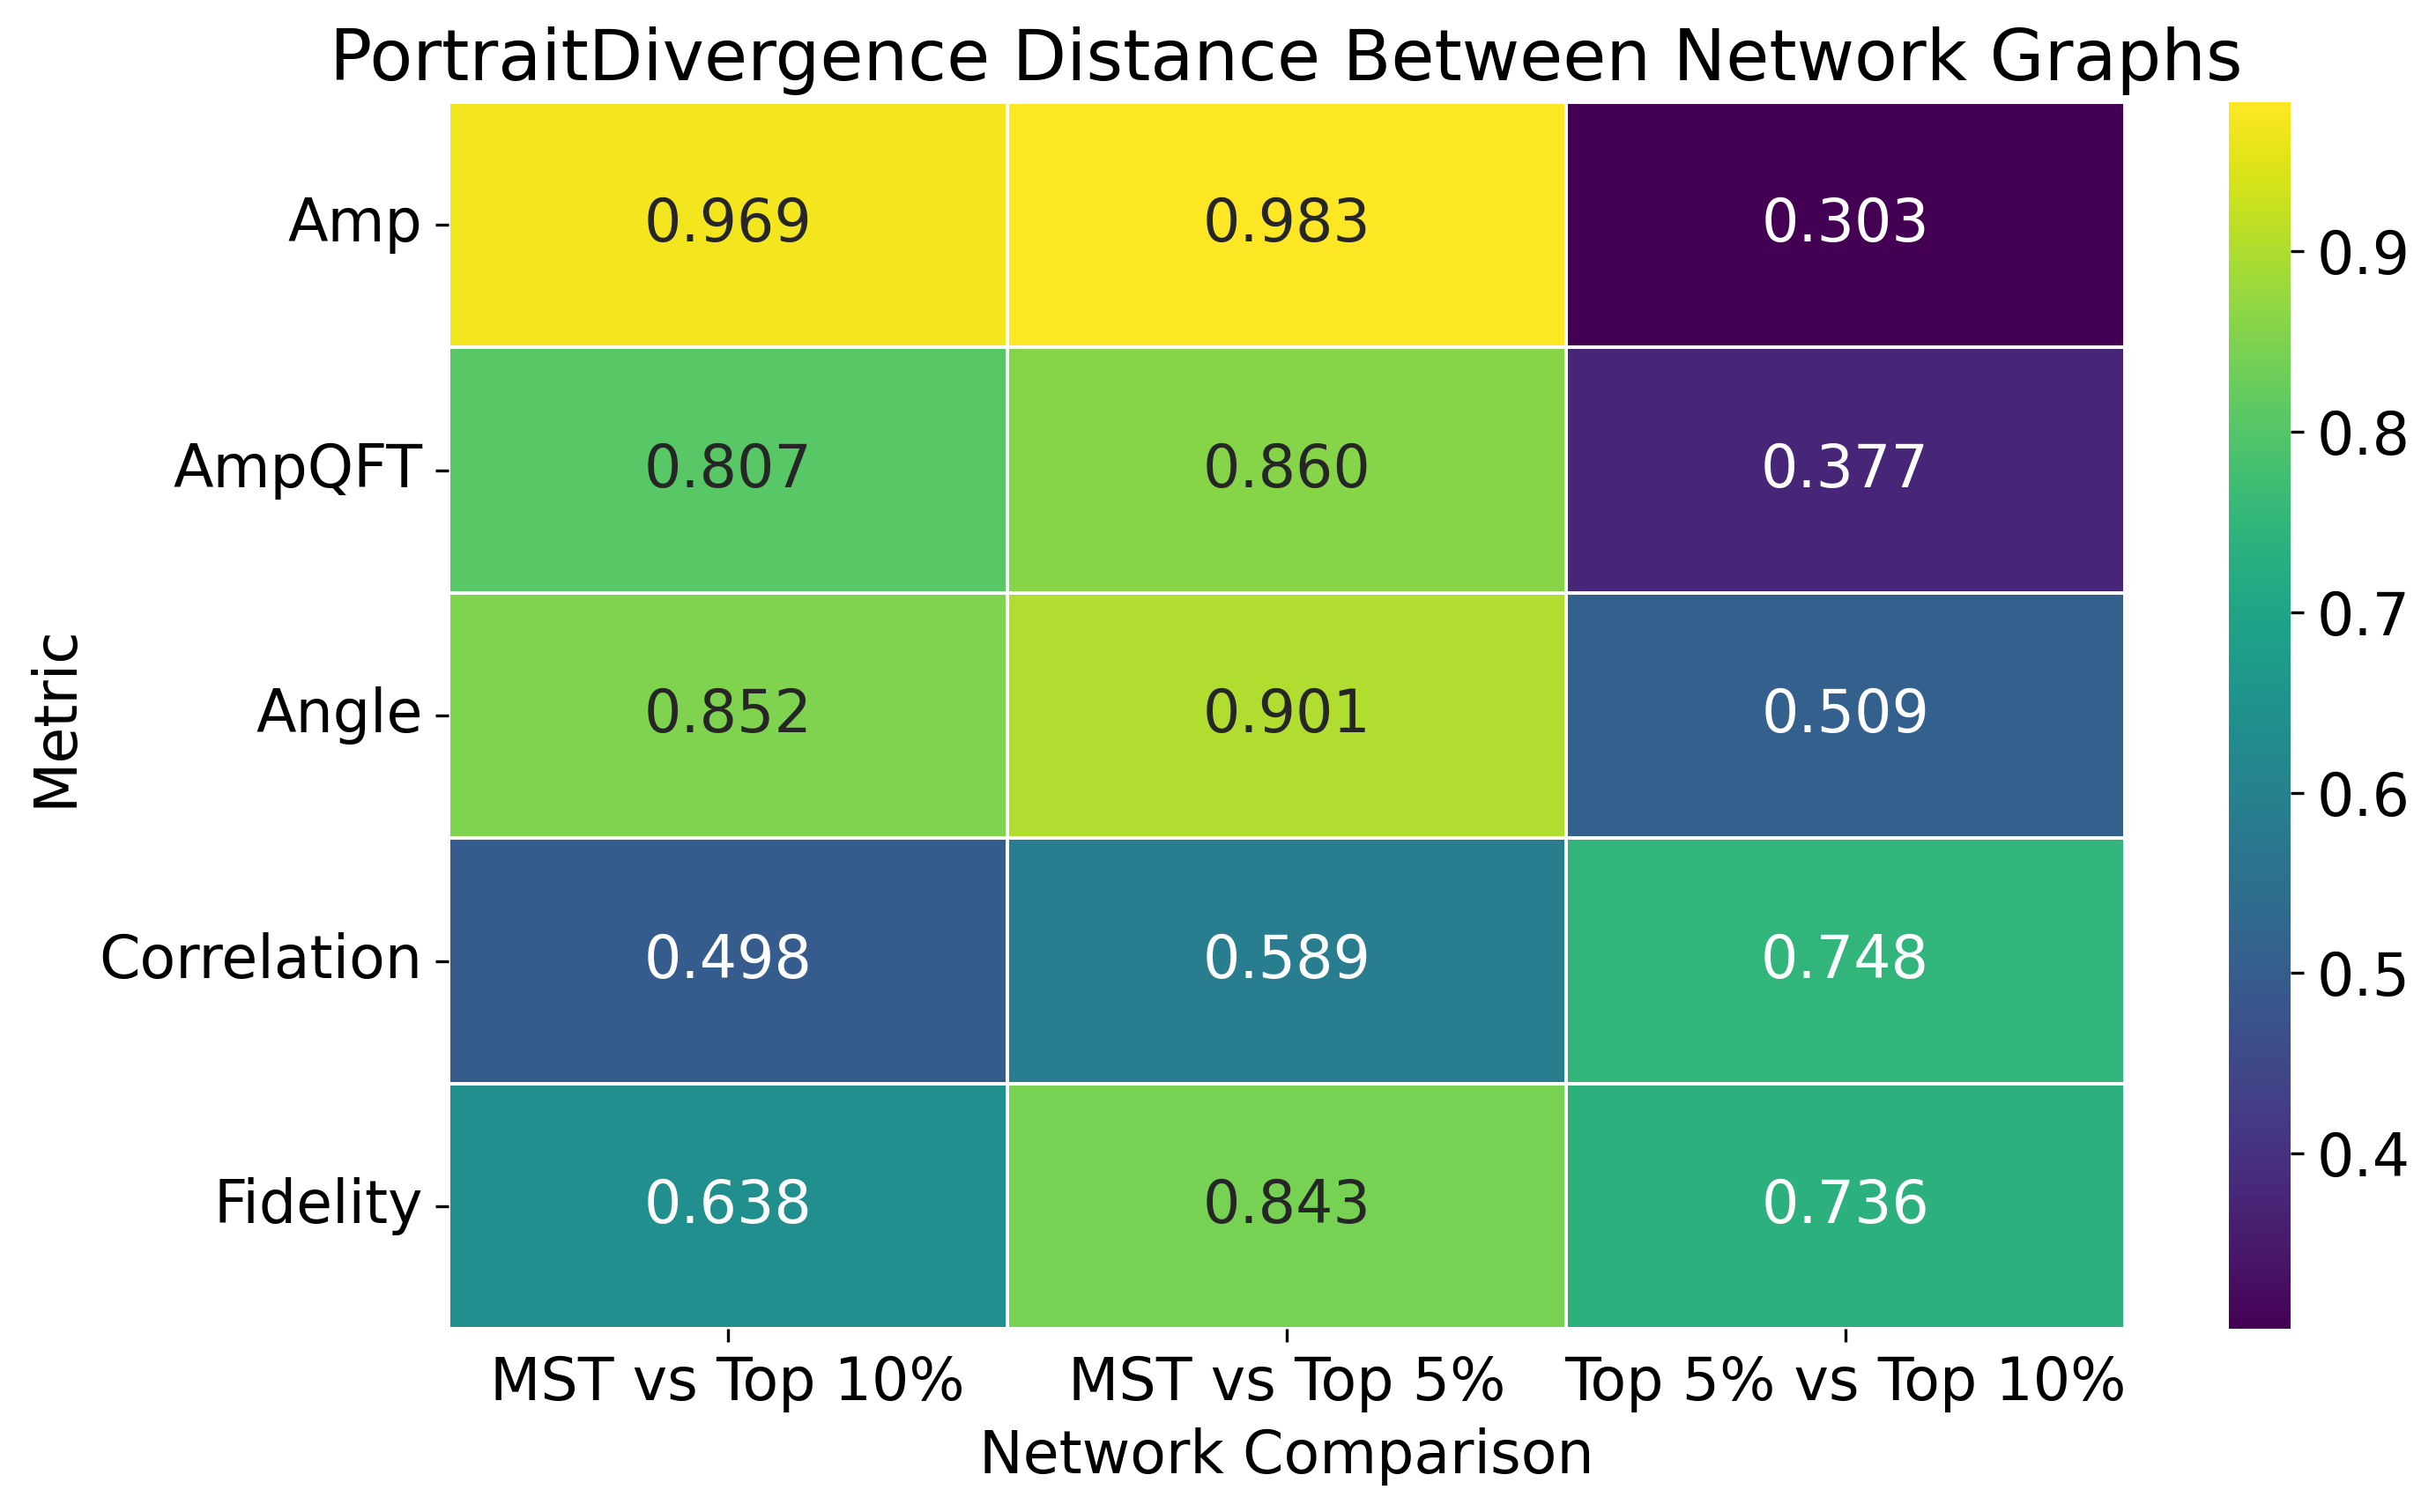

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16
# Loop through each metric and plot a heatmap
metrics = ['Jaccard', 'DeltaCon', 'QuantumJSD', 'PortraitDivergence']
for metric in metrics:
    # Pivot table: rows = Graph Type, columns = Comparison (Network1-Network2)
    pivot_df = clean_df.copy()
    pivot_df['Comparison'] = pivot_df['Network1'] + ' vs ' + pivot_df['Network2']
    heatmap_df = pivot_df.pivot(index='Graph Type', columns='Comparison', values=metric)

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
    plt.title(f"{metric} Distance Between Network Graphs")
    plt.xlabel("Network Comparison")
    plt.ylabel("Metric")
    plt.tight_layout()
    plt.savefig(FIGS + f'graph-distance-{metric}.png', dpi=300)
    plt.show()


# Rent's Analysis

Technically should use Robust Fit, but ordinary least squares will do

In [30]:
import numpy as np
import statsmodels.api as sm
from scipy import stats

def rentian_scaling_linreg(adj_matrix, coords, n=300, threshold=0.9, confidence=0.95):
    """
    Compute Rentian scaling slope and its confidence interval.

    Parameters:
    adj_matrix (numpy array): Adjacency matrix of the network.
    coords (numpy array): Coordinates of the nodes in the network.
    n (int, optional): Number of iterations for Rentian scaling. Defaults to 300.
    threshold (float, optional): Threshold for binarizing the adjacency matrix. Defaults to 0.9.
    confidence (float, optional): Confidence level for the interval. Defaults to 0.95.

    Returns:
    tuple: Computed slope and its confidence interval.
    """

    # Binarize the adjacency matrix
    # sc_matrix = adj_matrix
    # adj_matrix = (sc_matrix >= threshold).astype(int)
    # np.fill_diagonal(adj_matrix, 0)

    # Run Rentian scaling
    N, E = rentian_scaling(adj_matrix, coords, n=n)
    mask = (N > 0) & (E > 0)
    log_N = np.log10(N[mask]).reshape(-1, 1) #[mask]).reshape(-1, 1)
    log_E = np.log10(E[mask]).reshape(-1, 1) #[mask]).reshape(-1, 1)

    # Add a constant (intercept) to the independent value
    X = sm.add_constant(log_N)

    # Linear regression
    model = sm.OLS(log_E, X).fit()
    slope = model.params[1]
    intercept = model.params[0]
    r2 = model.rsquared

    # Confidence interval for the slope
    stderr = model.bse[1]
    interval = stats.t.ppf((1 + confidence) / 2, len(log_E) - 2) * stderr
    ci = (slope - interval, slope + interval)

    return slope, (slope, slope - interval, slope + interval), log_N, log_E, intercept, r2, ci


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_linear_regression(log_N, log_E, slope, intercept, r2, ax=None, confidence=0.95):
    if ax is None:
        ax = plt.gca()

    # Plot the data points
    ax.scatter(log_N, log_E, s=20, alpha=0.9, color='gray') # , label='Samples')

    # Plot the fitted line
    log_N_fit = np.linspace(log_N.min(), log_N.max(), 100).reshape(-1, 1)
    log_E_fit = slope * log_N_fit + intercept
    ax.plot(log_N_fit, log_E_fit, color='crimson', linewidth=2,
             label=f'Fit: slope = {slope:.2f}, $R^2$ = {r2:.2f}')

    ax.set_xlabel(r"log$_{10}$(Number of nodes in cube)")
    ax.set_ylabel(r"log$_{10}$(Number of crossing edges)")
    # ax.set_title("Linear Regression")
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(loc='lower right')


In [32]:
def plot_rentian_scaling_wrapper_grid(inputs, graph_labels, suffixes):
    plt.rcParams['font.size'] = 16
    
    plt.close()
    intervals = []
    fig, axes = plt.subplots(2, 5, figsize=(30, 13))
    axes = axes.flatten()
    j = 0
    for input_, sfx in zip(inputs, suffixes):
        for i in range(len(input_)):
            adj_matrix = input_[i]
            slope, interval, log_N, log_E, intercept, r2, ci = rentian_scaling_linreg(adj_matrix, coords.to_numpy())
            plot_linear_regression(log_N, log_E, slope, intercept, r2, ax=axes[j])
            # axes[j].set_title(j)
            if j % 5 != 0:
                axes[j].set_ylabel('')
            if j < 5:
                axes[j].set_xlabel('')
                axes[j].set_title(graph_labels[i], fontsize=20)
            j += 1
            intervals.append(interval)

    plt.suptitle(f'Rentian Scaling', fontsize=28)
    plt.tight_layout()
    plt.savefig(FIGS + 'rentian-scaling-grid.png', dpi=300)

    # plt.show()
    return intervals

In [33]:
intervals = plot_rentian_scaling_wrapper_grid(
    [
        # [nx.adjacency_matrix(m) for m in msts],  # gives 0-sized array, no analysis possible
        [nx.adjacency_matrix(m) for m in threshold_95],
        [nx.adjacency_matrix(m) for m in threshold_90]
    ],
    graph_labels,
    ['top 5%', 'top 10%'],
)
# big figure
plt.clf()
plt.close()

In [34]:
rent_exps_df = pd.DataFrame(intervals, columns=['linear $r^2$', 'low', 'high'])

In [35]:
rent_exps_df['metric'] = graph_labels*2 # string type
rent_exps_df['threshold'] = ['5%'] * 5 + ['10%'] * 5

In [36]:
# verify that rentian scaling is achieved
# yes r^2 can be negative infinity if the exponential law fit does not work
threshold_95_power_law_r2 = [is_rentian_scaling(m, coords, M=300) for m in [nx.adjacency_matrix(m) for m in threshold_95]]
threshold_95_power_law_r2 = [x[0] for x in threshold_95_power_law_r2]

Power law R^2: 0.75
Exponential law R^2: -7197035586004035405917192192.00
Rentian scaling achieved
Power law R^2: 0.25
Exponential law R^2: -3613735931478667795110035456.00
Rentian scaling achieved
Power law R^2: 0.45
Exponential law R^2: -14530107453973138186414092976128.00
Rentian scaling achieved
Power law R^2: 0.81
Exponential law R^2: -38990389863104676480671547392.00
Rentian scaling achieved
Power law R^2: 0.43
Exponential law R^2: -31887234524603063088011280384.00
Rentian scaling achieved


In [37]:
# verify that rentian scaling is achieved
threshold_90_power_law_r2 = [is_rentian_scaling(m, coords, M=300) for m in [nx.adjacency_matrix(m) for m in threshold_90]]
threshold_90_power_law_r2 = [x[0] for x in threshold_90_power_law_r2]

Power law R^2: 0.78
Exponential law R^2: -2402649810382177109280817152.00
Rentian scaling achieved
Power law R^2: 0.50
Exponential law R^2: -1518089451590908494127038464.00
Rentian scaling achieved
Power law R^2: 0.50
Exponential law R^2: -4643329644346152767674963197952.00
Rentian scaling achieved
Power law R^2: 0.76
Exponential law R^2: -12230132398412471141849366528.00
Rentian scaling achieved
Power law R^2: 0.51
Exponential law R^2: -11367065695735104608961298432.00
Rentian scaling achieved


Text(0.5, 1.0, 'Rent exponent')

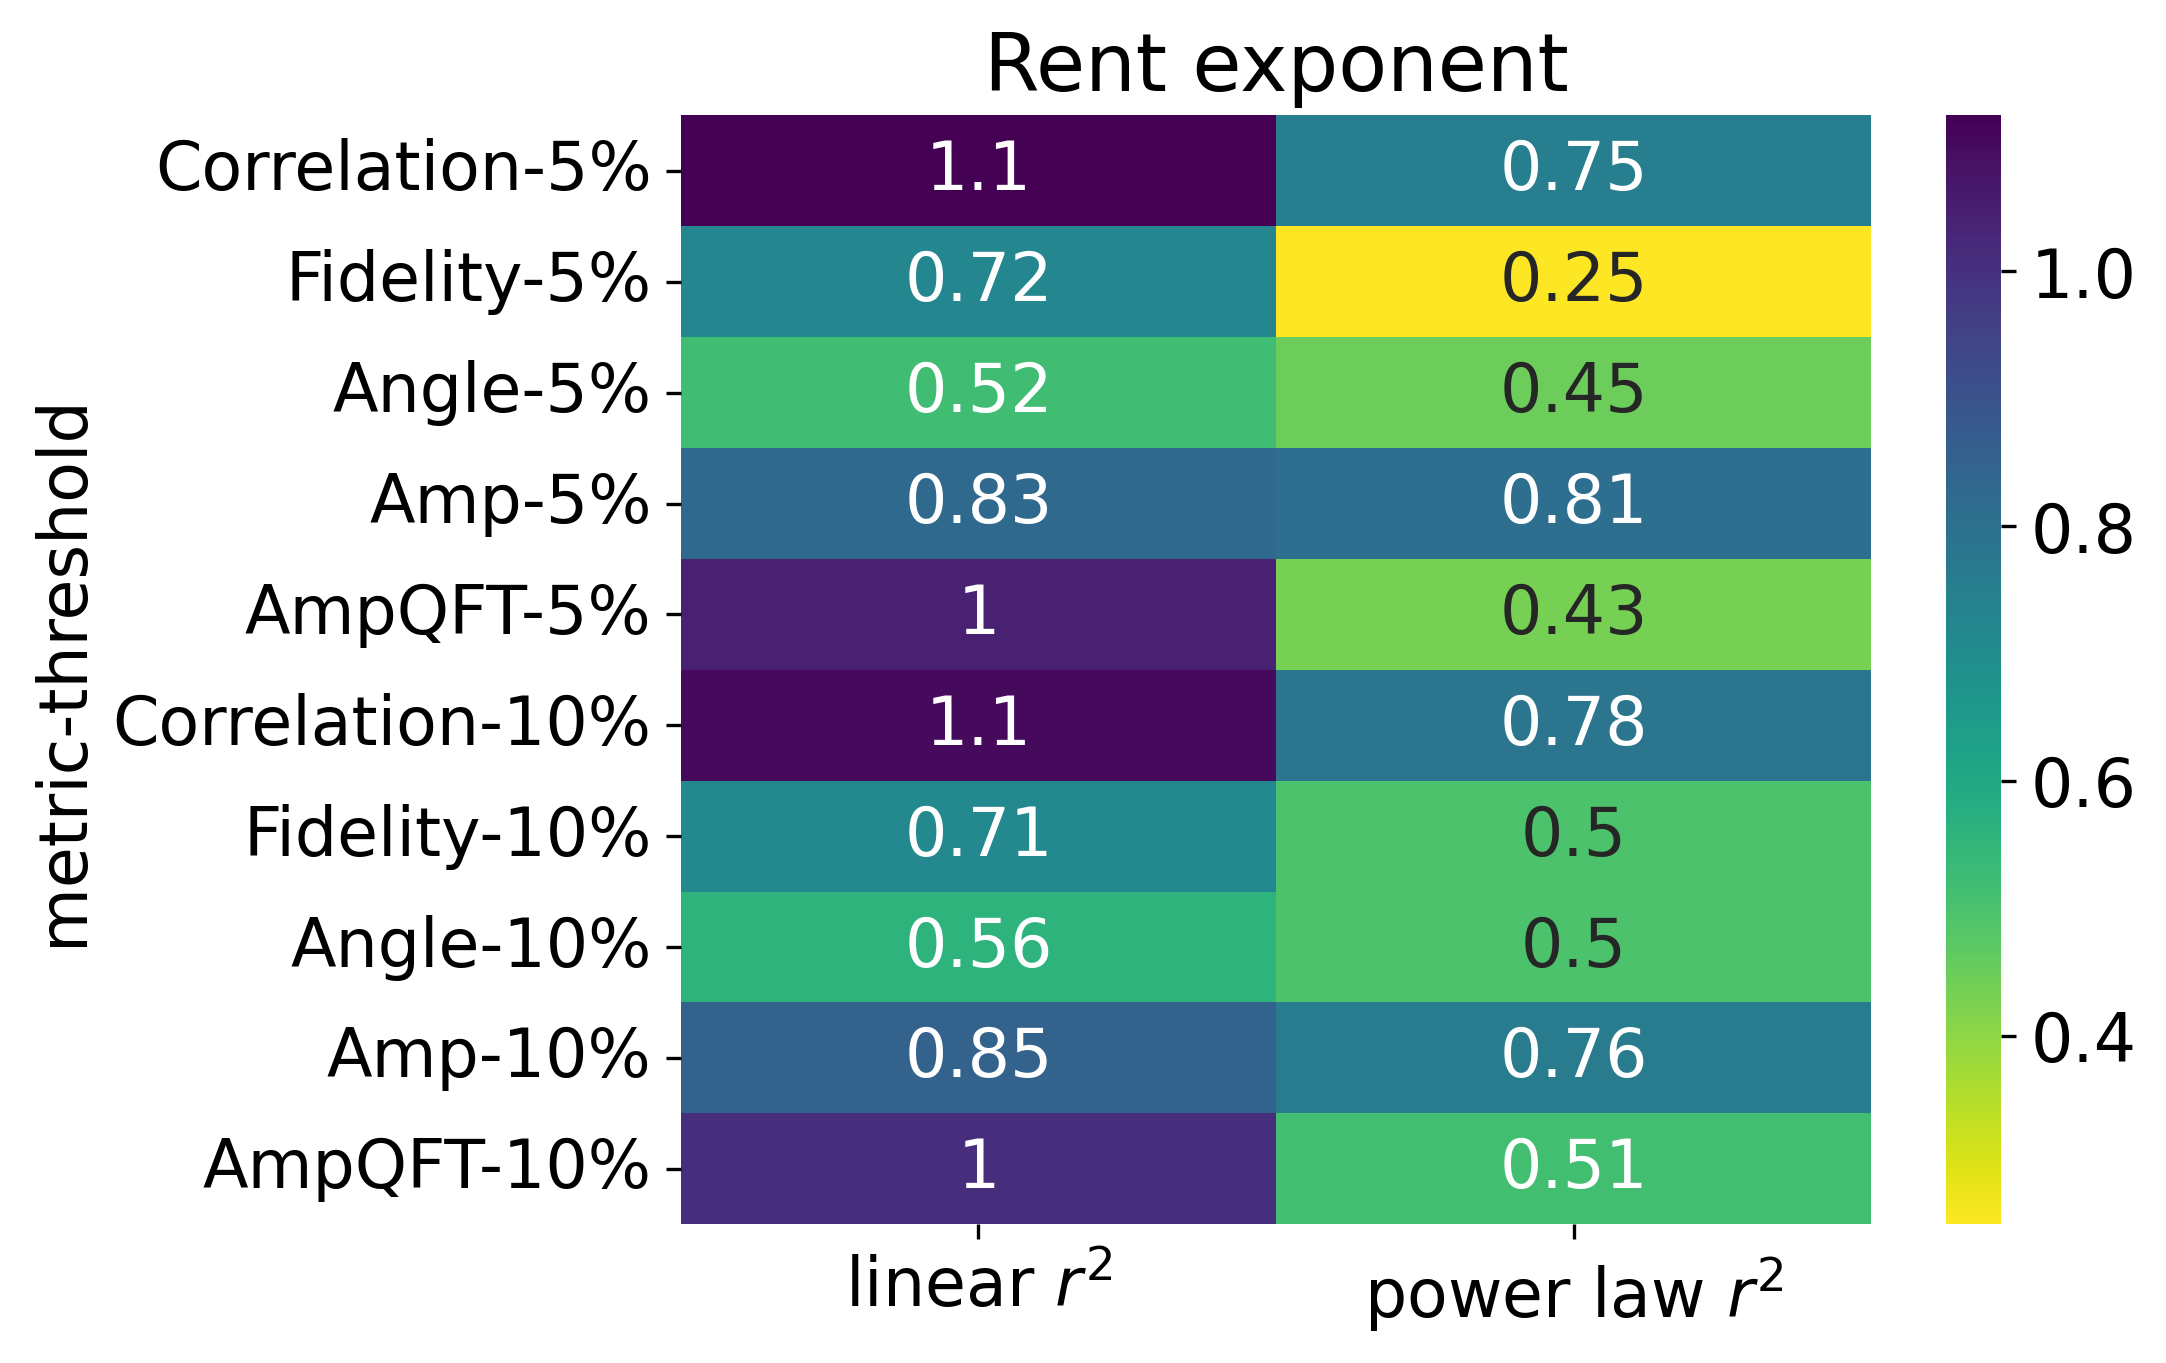

In [38]:
plt.rcParams['font.size'] = 16

rent_exp_df_for_plot = rent_exps_df.set_index(['metric', 'threshold']).drop(columns=['low', 'high'])
rent_exp_df_for_plot['power law $r^2$'] = threshold_95_power_law_r2 + threshold_90_power_law_r2
sns.heatmap(rent_exp_df_for_plot, annot=True, cmap='viridis_r')
plt.title('Rent exponent')

# Small world propensity

In [39]:
import small_world_propensity as swp

In [40]:
ms = [nx.adjacency_matrix(m).toarray() for m in threshold_95 + threshold_90]

In [41]:
its_a_small_world_after_all = swp.small_world_propensity(ms)

  0%|                                                                                                                                                                                                              | 0/10 [00:00<?, ?it/s]/home/user/work/quadrigems/notebooks/../src/small_world_propensity.py:62: RuntimeWarning: divide by zero encountered in divide
  path_matrix = csgraph.shortest_path(1/W, directed=False, unweighted=False)
/home/user/work/quadrigems/notebooks/../src/small_world_propensity.py:152: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.arctan(delta_L / delta_C)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 268.05it/s]


In [42]:
its_a_small_world_after_all['metric'] = graph_labels*2 # string type
its_a_small_world_after_all['threshold'] = ['5%'] * 5 + ['10%'] * 5

In [43]:
its_a_small_world_after_all = its_a_small_world_after_all.set_index(['metric', 'threshold'])
its_a_small_world_after_all

,,Network C,Network L,ΔC,ΔL,SWP,α,δ,Regular C,Random C,Regular L,Random L
metric,threshold,,,,,,,,,,,
Correlation,5%,0.253651,1.483359,0.227993,0.000000,0.838785,0.000000,-1.000000,0.326602,0.006631,12.338172,3.388911
Fidelity,5%,0.360653,2.886166,0.000000,0.000000,1.000000,NaN,NaN,0.248787,0.015688,16.361561,4.810077
Angle,5%,0.131087,2.227856,0.543370,0.000000,0.615779,0.000000,-1.000000,0.243780,0.036383,17.460640,4.313911
Amp,5%,0.027453,1.655252,0.980834,0.000000,0.306446,0.000000,-1.000000,0.229837,0.023498,18.899021,4.761190
AmpQFT,5%,0.030228,1.653102,0.943069,0.000000,0.333150,0.000000,-1.000000,0.243717,0.017340,17.627038,4.875792
Correlation,10%,0.323932,3.473011,0.383020,0.174853,0.702277,0.428256,-0.454727,0.481442,0.070210,6.937705,2.738822
Fidelity,10%,0.504831,2.840966,0.000000,0.000000,1.000000,NaN,NaN,0.354400,0.053641,10.121685,3.701687
Angle,10%,0.289158,2.900381,0.176540,0.000000,0.875167,0.000000,-1.000000,0.340143,0.051339,10.574508,3.831173
Amp,10%,0.052944,2.940186,0.961947,0.000000,0.319800,0.000000,-1.000000,0.311069,0.042733,12.181589,4.238289


In [44]:
its_a_small_world_after_all = its_a_small_world_after_all[['SWP']]

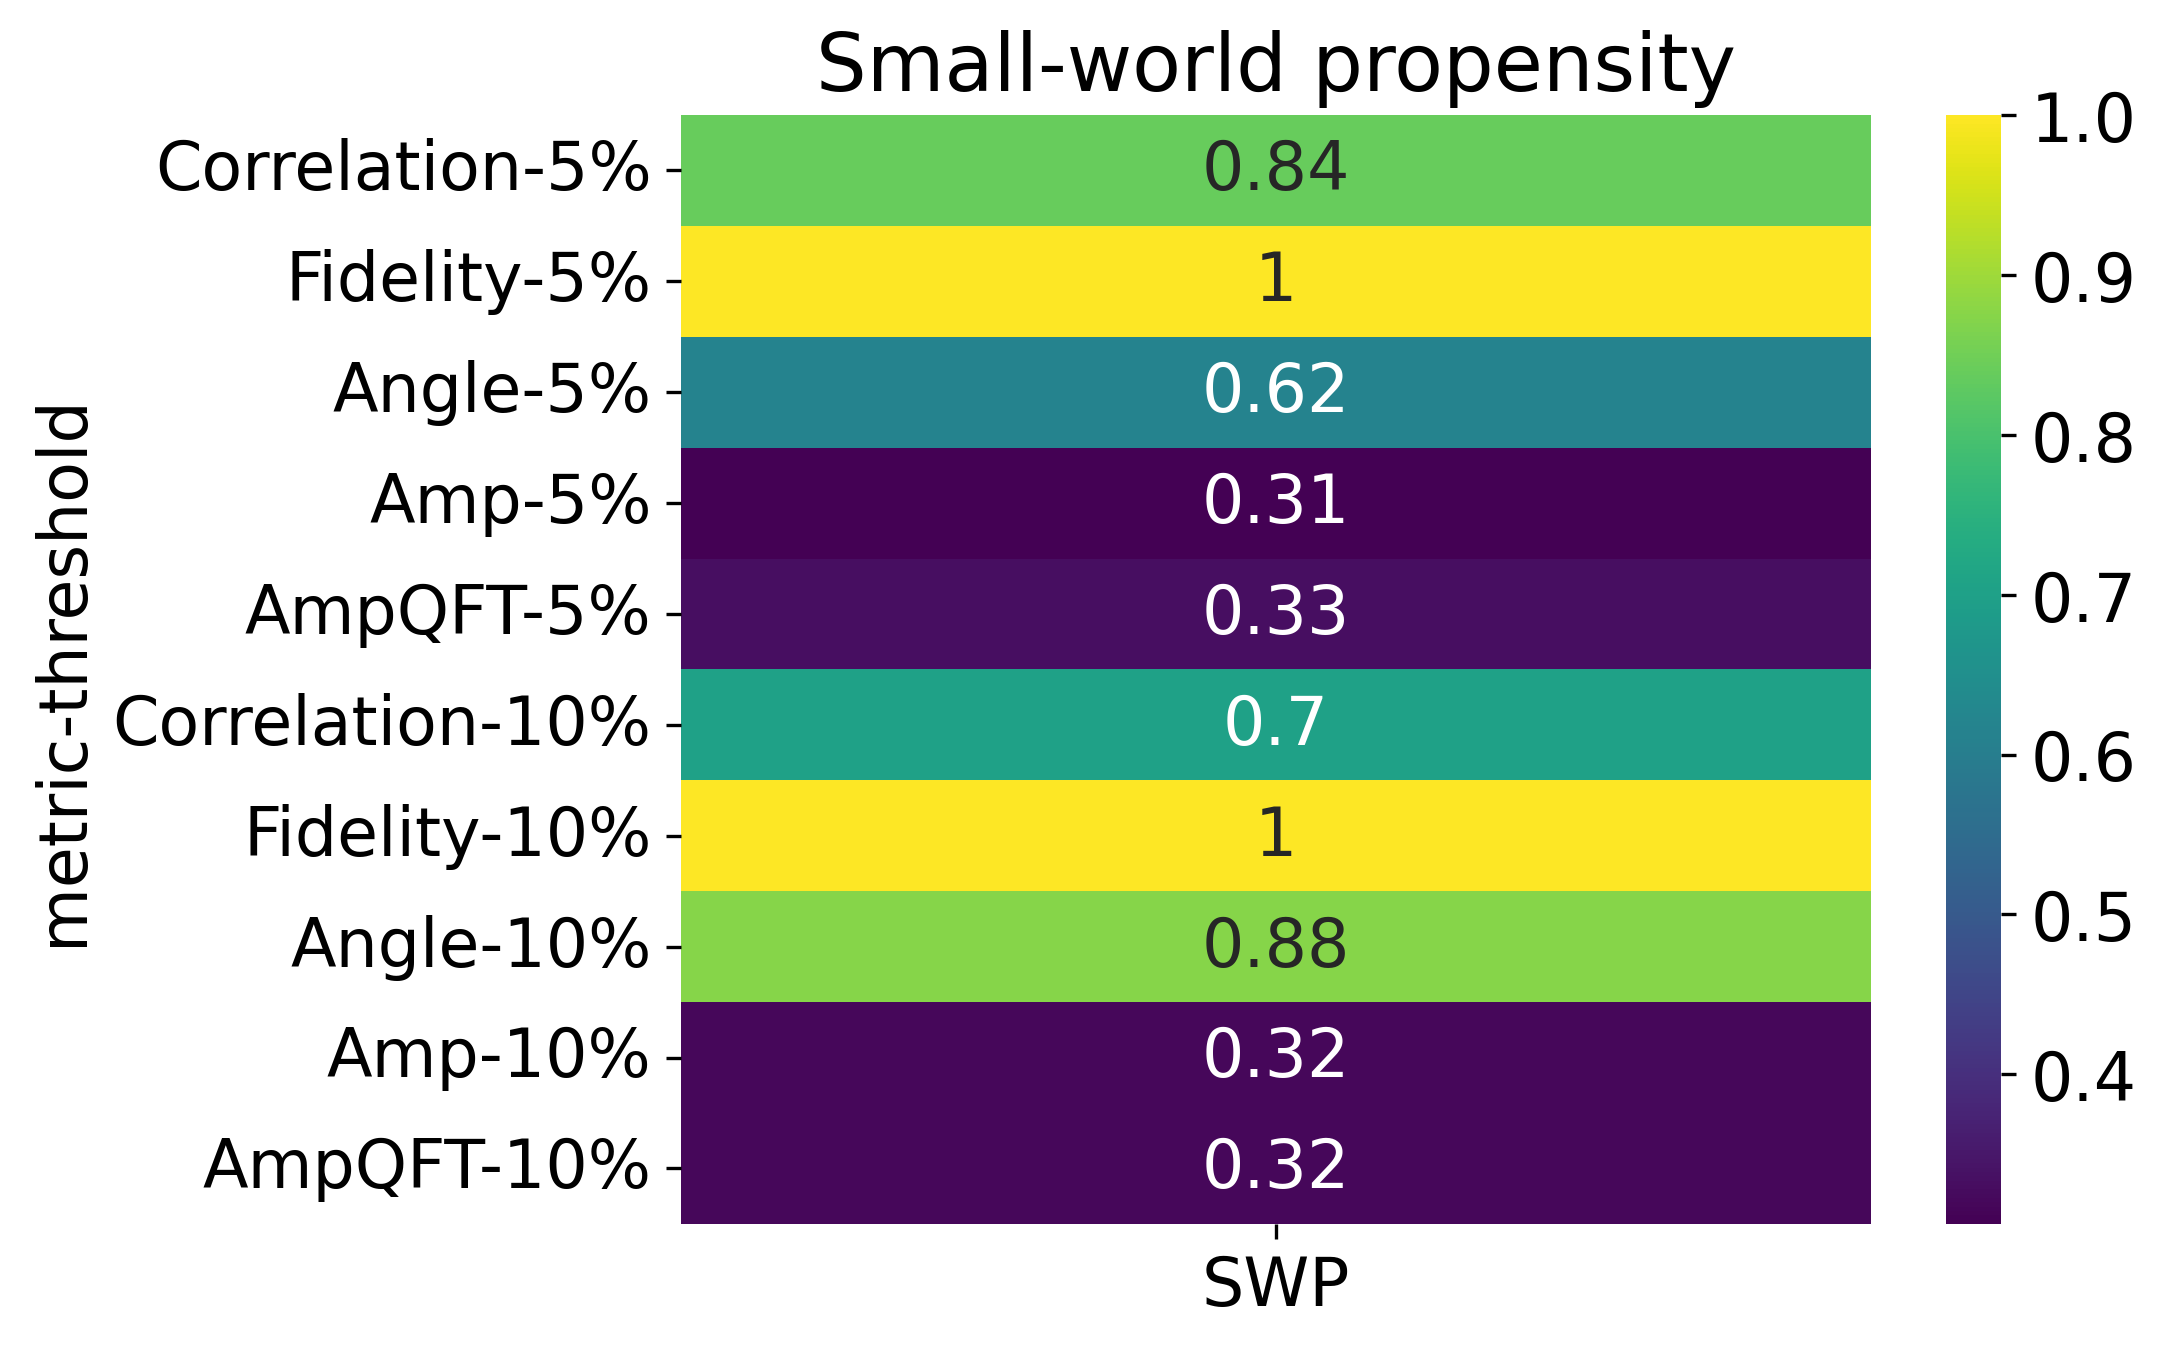

In [45]:
plt.rcParams['font.size'] = 16
sns.heatmap(its_a_small_world_after_all[['SWP']], annot=True, cmap='viridis')
# plt.title("It's a small world after all")
plt.title("Small-world propensity")
plt.show()

# Average and nearest neighbor distances



In [46]:
from tqdm.notebook import tqdm

In [47]:
def calculate_distances(G):
    # Extract node coordinates
    nodes = list(G.nodes)
    # Calculate nearest and average neighbor distance for each node
    nearest_nn_distances = []
    average_nn_distances = []
    for node in nodes:
        neighbors = list(G.neighbors(node))
        if neighbors:
            neighbor_positions = np.array([G.nodes[neighbor]['pos'] for neighbor in neighbors])
            node_position = G.nodes[node]['pos']
            # print(node_position, neighbor_positions[0])
            distances = [np.linalg.norm(neighbor_position - node_position) for neighbor_position in neighbor_positions]
            nearest_nn_distances.append(np.min(distances))
            average_nn_distances.append(np.mean(distances))

    return np.array(nearest_nn_distances), np.array(average_nn_distances)

In [48]:
og_graphs = [make_graph(m) for m in matrices]

In [49]:
distances_calcs = [calculate_distances(g) for g in itertools.chain(*[og_graphs, msts, threshold_95, threshold_90])]

In [50]:
distances_calcs_df = pd.DataFrame(distances_calcs, columns=['Average distance', 'Nearest neighbor distance'])

In [51]:
distances_calcs_df['metric'] = graph_labels*4 # string type
distances_calcs_df['threshold'] = ['Full'] * 5 + ['MST'] * 5 + ['5%'] * 5 + ['10%'] * 5

In [52]:
distances_calcs_df

,Average distance,Nearest neighbor distance,metric,threshold
0,"[14.561005619929627, 27.46067068043073, 7.2932...","[87.55396224921974, 86.65791440045429, 97.8807...",Correlation,Full
1,"[14.561005619929627, 27.46067068043073, 7.2932...","[87.55396224921974, 86.65791440045429, 97.8807...",Fidelity,Full
2,"[14.561005619929627, 27.46067068043073, 7.2932...","[87.55396224921974, 86.65791440045429, 97.8807...",Angle,Full
3,"[14.561005619929627, 27.46067068043073, 7.2932...","[87.55396224921974, 86.65791440045429, 97.8807...",Amp,Full
4,"[14.561005619929627, 27.46067068043073, 7.2932...","[87.55396224921974, 86.65791440045429, 97.8807...",AmpQFT,Full
5,"[48.448211892298986, 38.065044184773804, 38.06...","[48.448211892298986, 83.5470419927793, 129.304...",Correlation,MST
6,"[39.30043006089769, 141.83641884636359, 92.042...","[39.30043006089769, 141.83641884636359, 92.042...",Fidelity,MST
7,"[44.818940181437014, 39.42935310884425, 92.790...","[68.96278244703873, 47.91141826165216, 158.125...",Angle,MST
8,"[110.89498554872866, 31.301949385129827, 33.40...","[115.00693026774357, 47.919909512938005, 79.66...",Amp,MST
9,"[48.448211892298986, 38.065044184773804, 38.06...","[81.78713946232466, 84.09054456037619, 73.2483...",AmpQFT,MST


In [53]:
distances_calcs_df = distances_calcs_df.explode(['Average distance', 'Nearest neighbor distance'])

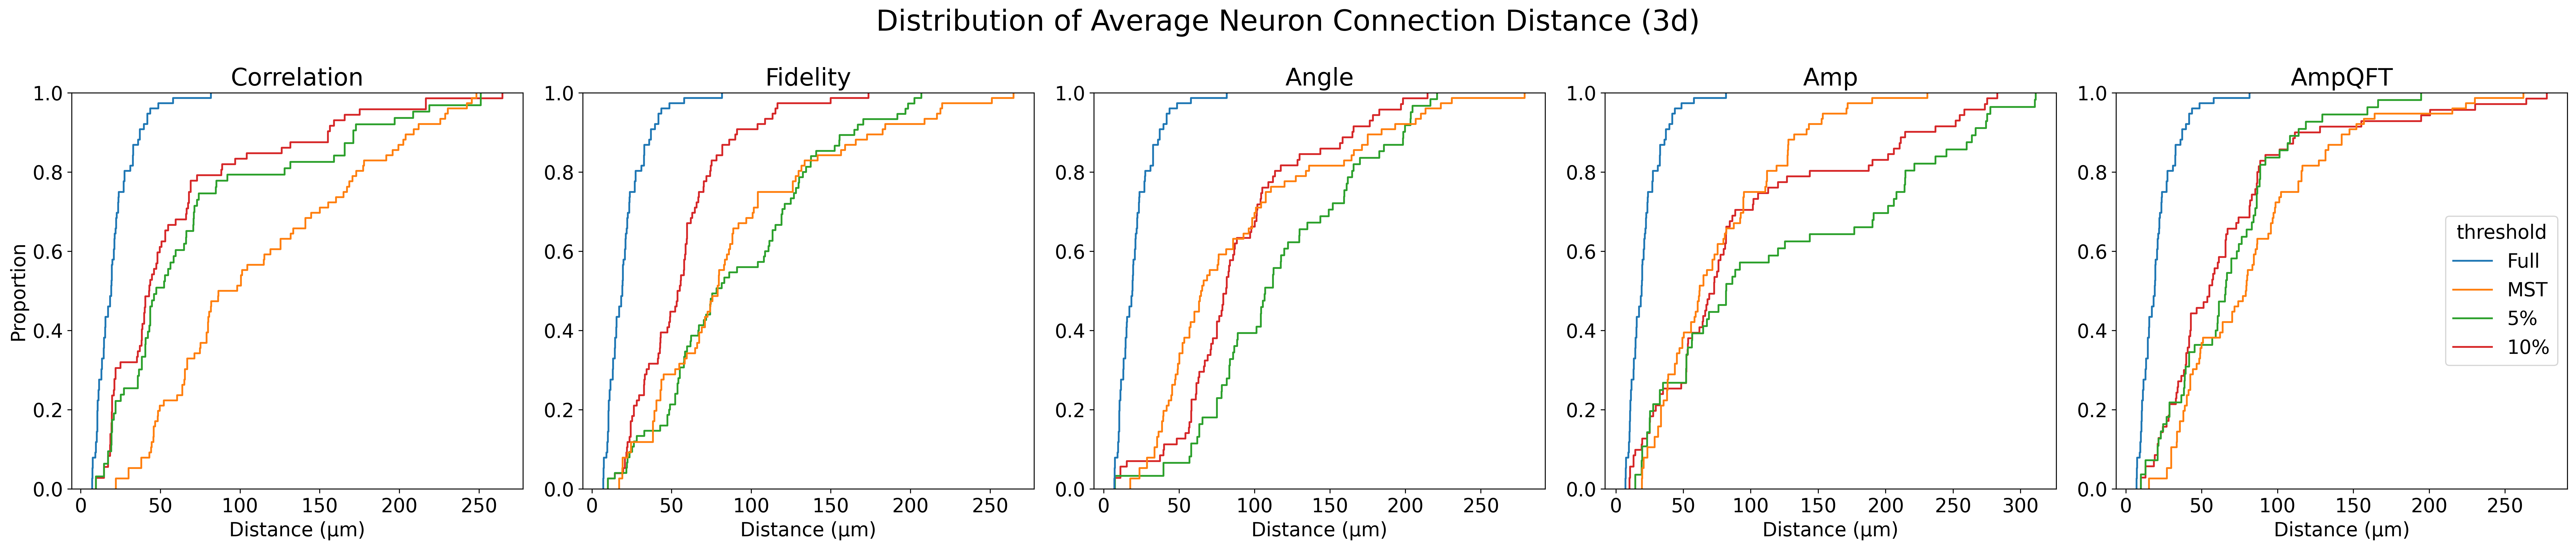

In [54]:
plt.close()
metric_names = graph_labels
# plt.close()
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(1, len(metric_names), figsize=(len(metric_names)*6, 6.5))

for i, metric in enumerate(metric_names):

    # Plot Distribution of Average Neuronal Connection Distances
    sns.ecdfplot(distances_calcs_df[distances_calcs_df['metric'] == metric], x='Average distance', hue='threshold', ax=axs[i])

    axs[i].set_title(metric, fontsize=20)
    axs[i].set_xlabel("Distance (μm)")

    leg = axs[i].get_legend()
    if i > 0:
        axs[i].set_ylabel('')
    if i == 4:
        leg.set_loc('center right')
    else:
        leg.set_visible(False)

plt.suptitle(f"Distribution of Average Neuron Connection Distance (3d)", fontsize=24)
plt.tight_layout()
plt.show()

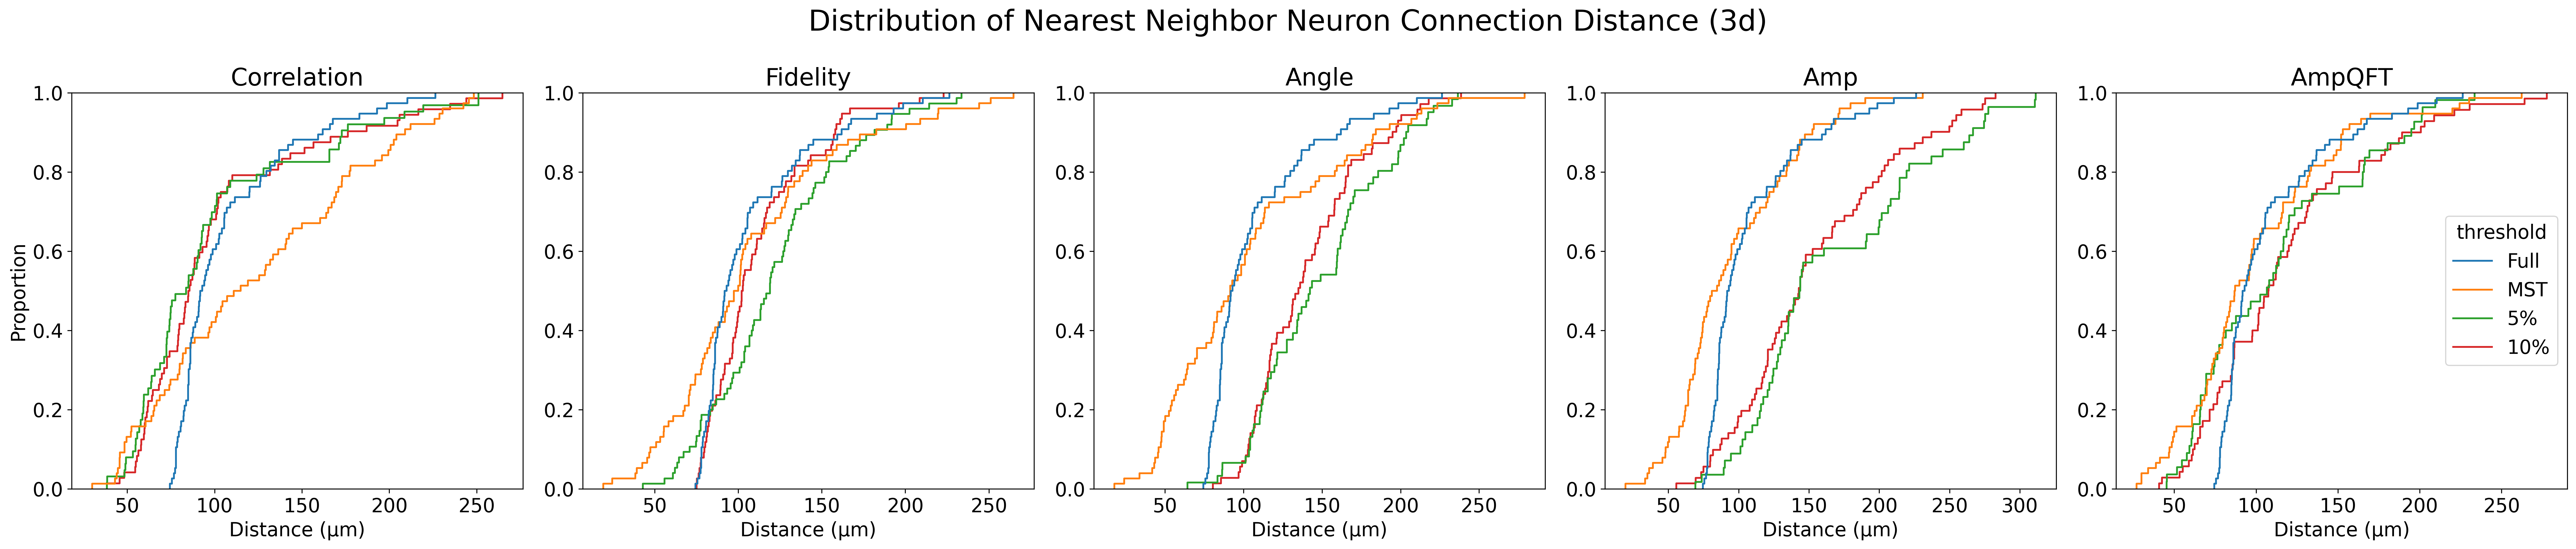

In [55]:
plt.close()
metric_names = graph_labels
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(1, len(metric_names), figsize=(len(metric_names)*6, 6.5))

for i, metric in enumerate(metric_names):

    # Plot Distribution of Average Neuronal Connection Distances
    sns.ecdfplot(distances_calcs_df[distances_calcs_df['metric'] == metric], x='Nearest neighbor distance', hue='threshold', ax=axs[i])

    axs[i].set_title(metric, fontsize=20)
    axs[i].set_xlabel("Distance (μm)")

    leg = axs[i].get_legend()
    if i > 0:
        axs[i].set_ylabel('')
    if i == 4:
        leg.set_loc('center right')
    else:
        leg.set_visible(False)

plt.suptitle(f"Distribution of Nearest Neighbor Neuron Connection Distance (3d)", fontsize=24)
plt.tight_layout()
plt.show()